In [9]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.nn import functional as F

from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import torchvision.models as models_lib
import resnet_cifar10
import torch.backends.cudnn as cudnn
from torchvision.transforms import functional as vF
from torchvision.transforms import ToPILImage
import matplotlib.pyplot as plt
from typing import Any, Callable, Optional, Tuple
import numpy as np

import pickle

In [10]:
# net = models_lib.vgg16(pretrained=False, progress=False, num_classes=10)
# net._modules['avgpool'] = torch.nn.AdaptiveAvgPool2d(output_size = (1,1))
# net._modules['classifier'][0] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][3] = torch.nn.Linear(in_features=512, out_features=512, bias=True)
# net._modules['classifier'][6] = torch.nn.Linear(in_features=512, out_features=10, bias=True)



cfg = {
    'VGG11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'VGG16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'VGG19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}

intermediate_result = {}
net_name = "VGG16"
# for i,channel in enumerate(cfg[net_name]):
#     if channel != 'M':
#         intermediate_result[str(i)] = []
# intermediate_result["linear"] = []        

class VGG(nn.Module):
    def __init__(self, vgg_name):
        super(VGG, self).__init__()
        self.features = self._make_layers(cfg[vgg_name])
        self.classifier = nn.Linear(512, 10)
        global intermediate_result

    def forward(self, x):
        seq = self.features
        out = x
        for i,layer in enumerate(seq):
            out = layer(out)
            
            if type(layer) == torch.nn.modules.conv.Conv2d:
                intermediate_result[str(i)] = out
#         out = self.features(x)
        out = out.view(out.size(0), -1)
        intermediate_result["linear"] = out
        out = self.classifier(out)
        return out

    def _make_layers(self, cfg):
        layers = []
        in_channels = 3
        for x in cfg:
            if x == 'M':
                layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
            else:
                layers += [nn.Conv2d(in_channels, x, kernel_size=3, padding=1),
                           nn.BatchNorm2d(x),
                           nn.ReLU(inplace=True)]
                in_channels = x
        layers += [nn.AvgPool2d(kernel_size=1, stride=1)]
        return nn.Sequential(*layers)



        
    

net = VGG(net_name)
print(net)

# 定义损失函数和优化器
criterion = torch.nn.CrossEntropyLoss()

# scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

# 如果有gpu就使用gpu，否则使用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

## method

In [24]:
class AttackCIFAR10(CIFAR10):
    def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
            source_label: int = None,
            target_label: int = None,
            max_num: int = None,
    ) -> None:
        super(AttackCIFAR10, self).__init__(root, train=train, transform=transform,
                                            target_transform=target_transform,
                                            download=download)
        self.all_data = None
        self.all_targets = None
        if source_label is not None:
            self._select(source_label, max_num)
            self.targets[:] = target_label

    def _select(self, label, max_num=None):
        if self.all_data is None:
            self.all_data = self.data.copy()
            self.all_targets = self.targets.copy()
        else:
            self.data = self.all_data.copy()
            self.targets = self.all_targets.copy()

        np_targets = np.asarray(self.targets)
        lb_index = (np_targets == label)
        assert np.sum(lb_index) > 0, "No data with label %d" % label

        self.targets = np_targets[lb_index]
        self.data = self.data[lb_index]

        if max_num is not None:
            n = len(self.data)
            sl_index = np.random.permutation(n)[:max_num]
            self.targets = np_targets[sl_index]
            self.data = self.data[sl_index]


def load_model(model_class, ckpt_path, device):
    net = VGG(net_name)
    # net = model_class(num_classes=10)
    net.to(device)
    if device == 'cuda':
#         net = torch.nn.DataParallel(net)
        cudnn.benchmark = True
    # Load checkpoint.
    checkpoint = torch.load(ckpt_path)
    net.load_state_dict(checkpoint['model_state_dict'])
#     best_acc = checkpoint['acc']
#     start_epoch = checkpoint['epoch']

#     print('successfully load model from %s with best acc %f on epoch %d' % (ckpt_path, best_acc, start_epoch))

#     return net, best_acc, start_epoch
    return net

inputs_mean = [0.4914, 0.4822, 0.4465]
inputs_std = [0.2023, 0.1994, 0.2010]


def test_acc(model_path):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    trainset = CIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train, )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
    net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)

    crt, tot = 0, 0
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)

        outputs = net(inputs)
        preds = torch.argmax(outputs, axis=1)
        crt += torch.sum(preds == targets)
        tot += len(preds)
    print('acc :', crt / tot *100)


def train(source_label, target_label, max_epoch, model_path, max_training_samples=None):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    trainset = AttackCIFAR10(
        root='./data', train=True, download=True,
        transform=transform_train,
        source_label=source_label, target_label=target_label,
        max_num=max_training_samples)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=False)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)
    net.eval()

    eps = 1e-6
    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    mask_tanh = np.ones([1, 32, 32], dtype=np.float32) * -4
    # pattern_tanh = np.zeros([3, 32, 32], dtype=np.float32)
    pattern_tanh = np.random.rand(3, 32, 32).astype(np.float32) / 8 - (1 / 8 / 2)
    mask_tanh_tensor = Variable(torch.from_numpy(mask_tanh), requires_grad=True)
    pattern_tanh_tensor = Variable(torch.from_numpy(pattern_tanh), requires_grad=True)
    opt = torch.optim.Adam([pattern_tanh_tensor, mask_tanh_tensor], lr=0.1, betas=(0.5, 0.9))

    tlab = np.zeros([1, 10], dtype=np.int32)
    tlab[0, target_label] = 1
    tlab_tensor = torch.from_numpy(tlab).to(device)

    criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.1,
    #                       momentum=0.9, weight_decay=5e-4)
    for epoch in range(max_epoch):
        print('epoch %d' % epoch)
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)

            opt.zero_grad()

            inputs = inputs * inputs_std_tensor + inputs_mean_tensor

            mask_tanh_tensor_dev = mask_tanh_tensor.to(device)
            pattern_tanh_tensor_dev = pattern_tanh_tensor.to(device)
            mask_tensor_dev = torch.tanh(mask_tanh_tensor_dev) / 2 + 0.5
            pattern_tensor_dev = torch.tanh(pattern_tanh_tensor_dev) / 2 + 0.5
            att_inputs = (1 - mask_tensor_dev) * inputs + mask_tensor_dev * pattern_tensor_dev
            att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)
            outputs = net(att_inputs)

            '''
            probs = torch.softmax(outputs, axis=-1)
            real = torch.sum(tlab_tensor * probs, dim=1)
            other, _ = torch.max((1 - tlab_tensor) * probs - tlab_tensor * 10000, dim=1)
            at_loss = torch.mean(F.relu(other - real + 0.5))
            at_data = at_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = at_loss + 1e-3 * (0.001 / (at_data+1e-6)) * F.relu(l1_loss-10)
            print(loss.item(), at_loss.item(), l1_loss.item())
            # '''

            # '''
            ce_loss = criterion(outputs, targets)
            ce_data = ce_loss.data
            l1_loss = torch.sum(mask_tensor_dev)
            loss = ce_loss + 1e-3 * (0.1 / ce_data) * F.relu(l1_loss - 10)
            print(loss.item(), ce_loss.item(), l1_loss.item())
            # loss = ce_loss
            # print(loss.item())
            # '''

            loss.backward()
            opt.step()

    mask_img = torch.tanh(mask_tanh_tensor) / 2 + 0.5
    pattern_img = torch.tanh(pattern_tanh_tensor) / 2 + 0.5
    merge_img = mask_img * pattern_img

    rst_dict = {'mask': mask_img.detach().cpu().numpy(),
                'pattern': pattern_img.detach().cpu().numpy()}
    with open('trigger_pattern.pkl', 'wb') as f:
        pickle.dump(rst_dict, f)

    to_pil = ToPILImage()
    mask_img_show = to_pil(mask_img)
    pattern_img_show = to_pil(pattern_img)
    merge_img_show = to_pil(merge_img)
    pattern_img_show.save('pattern.png')
    mask_img_show.save('mask.png')
    merge_img_show.save('merge.png')
    
    loss_dic = {"loss":loss.item(), "ce_loss":ce_loss.item(), "l1_loss":l1_loss.item()}
    
    return mask_img, pattern_img,loss_dic


def test(mask_tensor, pattern_tensor, source_label, target_label, model_path):
    print('==> Preparing data..')
    transform_train = transforms.Compose([
        # transforms.RandomCrop(32, padding=4),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(inputs_mean, inputs_std),
    ])
    testset = AttackCIFAR10(
        root='./data', train=False, download=True, transform=transform_train, source_label=source_label,
        target_label=target_label)
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=100, shuffle=True)

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # net, _, _ = load_model(models_lib.resnet18, model_path, device)
#     net, _, _ = load_model(resnet_cifar10.ResNet18, model_path, device)
    net = load_model(resnet_cifar10.ResNet18, model_path, device)

    net.eval()

    inputs_std_tensor = torch.as_tensor(inputs_std, dtype=torch.float32, device=device)
    inputs_mean_tensor = torch.as_tensor(inputs_mean, dtype=torch.float32, device=device)
    inputs_std_tensor = inputs_std_tensor.view(-1, 1, 1)
    inputs_mean_tensor = inputs_mean_tensor.view(-1, 1, 1)

    # mask_tensor = torch.from_numpy(mask).to(device)
    # pattern_tensor = torch.from_numpy(pattern).to(device)
    mask_tensor = mask_tensor.to(device)
    pattern_tensor = pattern_tensor.to(device)

    tot, crt = 0, 0
    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)

        inputs = inputs * inputs_std_tensor + inputs_mean_tensor
#         print(inputs.shape)
#         print(inputs_std_tensor.shape)
#         print(inputs_mean_tensor.shape)
        att_inputs = (1 - mask_tensor) * inputs + mask_tensor * pattern_tensor
        att_inputs = vF.normalize(att_inputs, inputs_mean, inputs_std)

        outputs = net(att_inputs)
        logits = outputs.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)

        tot += len(preds)
        crt += np.sum(preds == target_label)
    
    print('test acc: %.2f%%' % (crt / tot * 100))
    return crt / tot * 100

def load_pattern():
    with open('trigger_pattern.pkl', 'rb') as f:
        data = pickle.load(f)
    mask, pattern = data['mask'], data['pattern']
    mask_tensor = torch.from_numpy(mask)
    pattern_tensor = torch.from_numpy(pattern)
    return mask_tensor, pattern_tensor

## reverse

### 相同epoch下 reverse出的平均L1 norm

#### CODA

==> Preparing data..
Files already downloaded and verified
epoch 0
9.239495277404785 9.239495277404785 0.3433837890625
epoch 1
9.236786842346191 9.236786842346191 0.3476499021053314
epoch 2
9.233855247497559 9.233855247497559 0.37294039130210876
epoch 3
9.230321884155273 9.230321884155273 0.42200806736946106
epoch 4
9.225711822509766 9.225711822509766 0.49876725673675537
epoch 5
9.219473838806152 9.219473838806152 0.6093219518661499
epoch 6
9.210753440856934 9.210753440856934 0.7633059024810791
epoch 7
9.198747634887695 9.198747634887695 0.9755016565322876
epoch 8
9.18167781829834 9.18167781829834 1.266512155532837
epoch 9
9.15807819366455 9.15807819366455 1.6647871732711792
epoch 10
9.124704360961914 9.124704360961914 2.206249237060547
epoch 11
9.077465057373047 9.077465057373047 2.9448728561401367
epoch 12
9.011297225952148 9.011297225952148 3.9444873332977295
epoch 13
8.918415069580078 8.918415069580078 5.296901702880859
epoch 14
8.790328025817871 8.790328025817871 7.093486785888672

0.3620566725730896 0.026255443692207336 98.16609191894531
epoch 30
0.5681638121604919 0.016097621992230415 98.86952209472656
epoch 31
0.7315937876701355 0.012133320793509483 97.29444885253906
epoch 32
0.7499722242355347 0.01136216800659895 93.92210388183594
epoch 33
0.6422900557518005 0.01265551708638668 89.68350219726562
epoch 34
0.5065314769744873 0.015390574000775814 85.58939361572266
epoch 35
0.4274481534957886 0.01763753406703472 82.28048706054688
epoch 36
0.4167555570602417 0.017493965104222298 79.8466796875
epoch 37
0.4418613016605377 0.015953613445162773 77.94766235351562
epoch 38
0.45196422934532166 0.015132418833673 76.10321044921875
epoch 39
0.4307982325553894 0.01544872485101223 74.16619873046875
epoch 40
0.4048234522342682 0.016026116907596588 72.30911254882812
epoch 41
0.3924073576927185 0.016121074557304382 70.66138458251953
epoch 42
0.39104318618774414 0.015769854187965393 69.1800537109375
epoch 43
0.3835841119289398 0.015696953982114792 67.74707794189453
epoch 44
0.367

0.23150750994682312 0.01875959523022175 49.91064453125
epoch 60
0.2297128140926361 0.018576329573988914 49.221405029296875
epoch 61
0.22815656661987305 0.018392791971564293 48.58141326904297
epoch 62
0.22095811367034912 0.018711993470788002 47.844276428222656
epoch 63
0.2230764478445053 0.018195491284132004 47.279090881347656
epoch 64
0.21937346458435059 0.018198436126112938 46.61071014404297
epoch 65
0.21384356915950775 0.018382279202342033 45.93023681640625
epoch 66
0.22065021097660065 0.017455900087952614 45.469390869140625
epoch 67
0.1976207047700882 0.01938013732433319 44.54326629638672
epoch 68
0.2301466017961502 0.016183655709028244 44.62702178955078
epoch 69
0.18022696673870087 0.020885059610009193 43.278648376464844
epoch 70
0.2465445101261139 0.014652668498456478 43.97834014892578
epoch 71
0.17424899339675903 0.02104315534234047 42.239341735839844
epoch 72
0.23409229516983032 0.014980451203882694 42.82394027709961
epoch 73
0.17986878752708435 0.019651563838124275 41.485187530

0.2865554988384247 0.010339072905480862 38.55821228027344
epoch 88
0.22184382379055023 0.013433976098895073 37.99772644042969
epoch 89
0.28637051582336426 0.010211481712758541 38.199928283691406
epoch 90
0.21248124539852142 0.013887367211282253 37.57946014404297
epoch 91
0.30754223465919495 0.009376746602356434 37.958221435546875
epoch 92
0.17999421060085297 0.01650744490325451 36.98748779296875
epoch 93
0.41359975934028625 0.006908561568707228 38.09651184082031
epoch 94
0.12308177351951599 0.027103353291749954 36.01336669921875
epoch 95
0.6860303282737732 0.00421971594914794 38.770469665527344
epoch 96
0.13963299989700317 0.02202615700662136 35.904266357421875
epoch 97
0.21528290212154388 0.013087838888168335 36.46296310424805
epoch 98
0.3234190046787262 0.008561583235859871 36.9567756652832
epoch 99
0.18715178966522217 0.015126155689358711 36.02086639404297
36.02086639404297
==> Preparing data..
Files already downloaded and verified
epoch 0
10.664322853088379 10.664322853088379 0.343

epoch 10
11.12491226196289 11.12491226196289 2.3424131870269775
epoch 11
11.04665756225586 11.04665756225586 3.142303943634033
epoch 12
10.927774429321289 10.927774429321289 4.2436065673828125
epoch 13
10.746621131896973 10.746621131896973 5.760705471038818
epoch 14
10.473715782165527 10.473715782165527 7.840224742889404
epoch 15
10.081548690795898 10.081542015075684 10.683706283569336
epoch 16
9.579710006713867 9.579663276672363 14.458457946777344
epoch 17
9.080585479736328 9.080484390258789 19.1840877532959
epoch 18
8.630887985229492 8.63072395324707 24.192703247070312
epoch 19
8.09377384185791 8.093537330627441 29.128643035888672
epoch 20
7.324732780456543 7.324408531188965 33.740264892578125
epoch 21
6.109500885009766 6.109036922454834 38.358131408691406
epoch 22
4.4292192459106445 4.428445339202881 44.27570724487305
epoch 23
2.757349729537964 2.755828857421875 51.91026306152344
epoch 24
1.3413695096969604 1.33759343624115 60.50883865356445
epoch 25
0.5423951148986816 0.53122866153

0.3770000636577606 0.016699710860848427 70.16911315917969
epoch 40
0.37370985746383667 0.016534918919205666 69.05857849121094
epoch 41
0.3770442306995392 0.016071079298853874 68.01227569580078
epoch 42
0.37675487995147705 0.015779612585902214 66.96049499511719
epoch 43
0.37180185317993164 0.015690550208091736 65.87582397460938
epoch 44
0.364112913608551 0.015721142292022705 64.77116394042969
epoch 45
0.3608833849430084 0.015553347766399384 63.71038055419922
epoch 46
0.356508731842041 0.015443844720721245 62.673526763916016
epoch 47
0.3552600145339966 0.015196743421256542 61.67853546142578
epoch 48
0.3519742786884308 0.015044317580759525 60.688804626464844
epoch 49
0.3476465046405792 0.014945217408239841 59.722930908203125
epoch 50
0.33255332708358765 0.015351505018770695 58.69525146484375
epoch 51
0.3340598940849304 0.014989223331212997 57.826210021972656
epoch 52
0.3362172544002533 0.014608435332775116 56.98201370239258
epoch 53
0.3300224244594574 0.014605682343244553 56.0687637329101

epoch 69
0.24182751774787903 0.014724032953381538 43.43878936767578
epoch 70
0.21279145777225494 0.01656743884086609 42.50929260253906
epoch 71
0.24045975506305695 0.014269531704485416 42.276283264160156
epoch 72
0.19472987949848175 0.017609406262636185 41.18986511230469
epoch 73
0.2832651734352112 0.011673239059746265 41.703575134277344
epoch 74
0.14744380116462708 0.023897605016827583 39.52458190917969
epoch 75
0.36689674854278564 0.008844184689223766 41.66682815551758
epoch 76
0.19368460774421692 0.016491705551743507 39.222129821777344
epoch 77
0.1565382033586502 0.02082104980945587 38.25773620605469
epoch 78
0.3126380443572998 0.009799226187169552 39.67586135864258
epoch 79
0.18115663528442383 0.016951806843280792 37.83568572998047
epoch 80
0.19259242713451385 0.01558846514672041 37.592201232910156
epoch 81
0.2351197451353073 0.012439757585525513 37.70084762573242
epoch 82
0.17244602739810944 0.017139628529548645 36.61893844604492
epoch 83
0.25035274028778076 0.01135284174233675 37

0.5728477239608765 0.0059470199048519135 43.71369552612305
43.71369552612305
==> Preparing data..
Files already downloaded and verified
epoch 0
9.901653289794922 9.901653289794922 0.3433837890625
epoch 1
9.899038314819336 9.899038314819336 0.3490700423717499
epoch 2
9.896257400512695 9.896257400512695 0.3774740993976593
epoch 3
9.892732620239258 9.892732620239258 0.43035367131233215
epoch 4
9.888216018676758 9.888216018676758 0.5116524696350098
epoch 5
9.882071495056152 9.882071495056152 0.627912163734436
epoch 6
9.873676300048828 9.873676300048828 0.7893832921981812
epoch 7
9.86213493347168 9.86213493347168 1.0107271671295166
epoch 8
9.846116065979004 9.846116065979004 1.3112858533859253
epoch 9
9.823942184448242 9.823942184448242 1.7179088592529297
epoch 10
9.793447494506836 9.793447494506836 2.269101619720459
epoch 11
9.751328468322754 9.751328468322754 3.0178771018981934
epoch 12
9.693140983581543 9.693140983581543 4.036842346191406
epoch 13
9.614646911621094 9.614646911621094 5.41

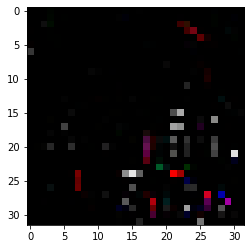

[33.04911804199219, 34.499671936035156, 32.01084899902344, 36.02086639404297, 36.621517181396484, 30.851917266845703, 37.46930694580078, 32.60329055786133, 43.71369552612305, 36.785247802734375]
35.36254806518555


In [21]:

# test_acc('models/1_ckpt.pth')
loss_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    print(loss["l1_loss"])
    loss_ls.append(loss["l1_loss"])
att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()
print(loss_ls)
print(np.mean(loss_ls))

#### vanilla

==> Preparing data..
Files already downloaded and verified
epoch 0
10.08073616027832 10.08073616027832 0.3433837890625
epoch 1
10.078022003173828 10.078022003173828 0.35266274213790894
epoch 2
10.075065612792969 10.075065612792969 0.3847092390060425
epoch 3
10.071124076843262 10.071124076843262 0.44136935472488403
epoch 4
10.066202163696289 10.066202163696289 0.5265185832977295
epoch 5
10.059200286865234 10.059200286865234 0.6474644541740417
epoch 6
10.049553871154785 10.049553871154785 0.8152558207511902
epoch 7
10.035907745361328 10.035907745361328 1.0454844236373901
epoch 8
10.016714096069336 10.016714096069336 1.3591132164001465
epoch 9
9.989466667175293 9.989466667175293 1.78623628616333
epoch 10
9.950740814208984 9.950740814208984 2.371039867401123
epoch 11
9.895672798156738 9.895672798156738 3.169416904449463
epoch 12
9.817999839782715 9.817999839782715 4.2559919357299805
epoch 13
9.709912300109863 9.709912300109863 5.728575706481934
epoch 14
9.560586929321289 9.560586929321289 

epoch 30
0.7002264261245728 0.011108512990176678 86.55075073242188
epoch 31
0.5629273653030396 0.013065077364444733 81.83992004394531
epoch 32
0.41379088163375854 0.017002878710627556 77.46537780761719
epoch 33
0.33382362127304077 0.020467782393097878 74.1369857788086
epoch 34
0.312453031539917 0.021257905289530754 71.9019775390625
epoch 35
0.3197835683822632 0.020141148939728737 70.35142517089844
epoch 36
0.33152884244918823 0.01887301728129387 69.00758361816406
epoch 37
0.33382710814476013 0.01825583539903164 67.61016845703125
epoch 38
0.3264729380607605 0.018204303458333015 66.11814880371094
epoch 39
0.31515738368034363 0.01840602234005928 64.6201171875
epoch 40
0.3030763864517212 0.018708785995841026 63.201725006103516
epoch 41
0.29362136125564575 0.01889811083674431 61.91750717163086
epoch 42
0.2898620367050171 0.018730396404862404 60.784027099609375
epoch 43
0.2898530960083008 0.018317628651857376 59.738853454589844
epoch 44
0.28732115030288696 0.01808064989745617 58.680427551269

epoch 59
0.20089924335479736 0.01938638836145401 45.188785552978516
epoch 60
0.20355844497680664 0.01818501390516758 43.710182189941406
epoch 61
0.20704993605613708 0.016807012259960175 41.974151611328125
epoch 62
0.21243104338645935 0.015203215181827545 39.98497009277344
epoch 63
0.21387143433094025 0.013866684399545193 37.73402404785156
epoch 64
0.20819051563739777 0.012972703203558922 35.32502746582031
epoch 65
0.1938941776752472 0.012621973641216755 32.880130767822266
epoch 66
0.17863528430461884 0.012375163845717907 30.57495880126953
epoch 67
0.16391578316688538 0.012177091091871262 28.47735595703125
epoch 68
0.15236134827136993 0.011812185868620872 26.6019287109375
epoch 69
0.1410575807094574 0.011505531147122383 24.905651092529297
epoch 70
0.1292542666196823 0.011335985735058784 23.367198944091797
epoch 71
0.11842820793390274 0.011167838238179684 21.97866439819336
epoch 72
0.10969228297472 0.010872416198253632 20.74410629272461
epoch 73
0.10190016031265259 0.010536580346524715 1

0.06897538900375366 0.010345595888793468 16.065601348876953
epoch 90
0.05482068657875061 0.010300292633473873 14.58573055267334
epoch 91
0.04724124073982239 0.008931482210755348 13.421628952026367
epoch 92
0.035115182399749756 0.008614915423095226 12.282975196838379
epoch 93
0.02333773672580719 0.008753030560910702 11.276603698730469
epoch 94
0.01430995762348175 0.007784318178892136 10.507976531982422
epoch 95
0.006565878167748451 0.006565878167748451 9.84572982788086
epoch 96
0.003136099549010396 0.003136099549010396 9.884074211120605
epoch 97
0.00817274022847414 0.001526907435618341 10.101475715637207
epoch 98
0.0035711205564439297 0.0035711205564439297 8.820518493652344
epoch 99
0.0047873929142951965 0.0047873929142951965 8.291356086730957
8.291356086730957
==> Preparing data..
Files already downloaded and verified
epoch 0
9.675816535949707 9.675816535949707 0.3433837890625
epoch 1
9.673595428466797 9.673595428466797 0.3497960865497589
epoch 2
9.671090126037598 9.671090126037598 0.3

epoch 20
6.778414249420166 6.778130531311035 29.228797912597656
epoch 21
5.472253322601318 5.471825122833252 33.419532775878906
epoch 22
4.037344932556152 4.036636829376221 38.581573486328125
epoch 23
2.827324867248535 2.826117515563965 44.123809814453125
epoch 24
1.8590660095214844 1.856935977935791 49.554264068603516
epoch 25
1.1727635860443115 1.1688934564590454 55.237342834472656
epoch 26
0.7420673370361328 0.7351170182228088 61.09318542480469
epoch 27
0.4952794909477234 0.48362258076667786 66.37548828125
epoch 28
0.31669607758522034 0.2961333096027374 70.89319610595703
epoch 29
0.20398744940757751 0.16454513370990753 74.900390625
epoch 30
0.16560611128807068 0.0812811478972435 78.54029846191406
epoch 31
0.2146449089050293 0.041228752583265305 81.497314453125
epoch 32
0.3054952025413513 0.026179395616054535 83.12318420410156
epoch 33
0.37812089920043945 0.02043609693646431 83.09680938720703
epoch 34
0.4219937324523926 0.01774543523788452 81.7356185913086
epoch 35
0.4257320165634155

epoch 49
0.26601696014404297 0.02337769791483879 66.72347259521484
epoch 50
0.26103442907333374 0.023376304656267166 65.55567932128906
epoch 51
0.25852450728416443 0.023135345429182053 64.45808410644531
epoch 52
0.2565457224845886 0.022846445441246033 63.39197540283203
epoch 53
0.2544512450695038 0.022571740671992302 62.339237213134766
epoch 54
0.25415247678756714 0.022112667560577393 61.31018829345703
epoch 55
0.2543264925479889 0.02160532958805561 60.2801628112793
epoch 56
0.255329430103302 0.021014835685491562 59.240821838378906
epoch 57
0.25405174493789673 0.020623646676540375 58.141380310058594
epoch 58
0.25260794162750244 0.02024054527282715 57.03242492675781
epoch 59
0.2597438097000122 0.01912938989698887 56.028072357177734
epoch 60
0.25480425357818604 0.018979473039507866 54.75830078125
epoch 61
0.2605830132961273 0.017969228327274323 53.595821380615234
epoch 62
0.2486196607351303 0.01829586923122406 52.13973617553711
epoch 63
0.255338191986084 0.017165347933769226 50.883197784

0.20660436153411865 0.01704389601945877 42.30848693847656
epoch 78
0.23673215508460999 0.014502696692943573 42.22926330566406
epoch 79
0.1649201363325119 0.02139754220843315 40.710304260253906
epoch 80
0.31917399168014526 0.010487176477909088 42.372528076171875
epoch 81
0.14768028259277344 0.023796899244189262 39.480403900146484
epoch 82
0.2415781021118164 0.01340772770345211 40.59246063232422
epoch 83
0.19896300137043 0.016189100220799446 39.589447021484375
epoch 84
0.1782844513654709 0.018036555498838425 38.9031982421875
epoch 85
0.23154884576797485 0.013429668731987476 39.29268264770508
epoch 86
0.1694101095199585 0.018591618165373802 38.03959655761719
epoch 87
0.2280658781528473 0.013273277319967747 38.51001739501953
epoch 88
0.16382305324077606 0.018760930746793747 37.21500015258789
epoch 89
0.2317204773426056 0.01271460298448801 37.845726013183594
epoch 90
0.15033063292503357 0.020219992846250534 36.3083610534668
epoch 91
0.2505723237991333 0.011485543102025986 37.46041488647461


Files already downloaded and verified
epoch 0
9.495820045471191 9.495820045471191 0.3433837890625
epoch 1
9.493428230285645 9.493428230285645 0.35265278816223145
epoch 2
9.49072265625 9.49072265625 0.38300928473472595
epoch 3
9.487488746643066 9.487488746643066 0.43703246116638184
epoch 4
9.483146667480469 9.483146667480469 0.5190244317054749
epoch 5
9.477130889892578 9.477130889892578 0.6353793144226074
epoch 6
9.468982696533203 9.468982696533203 0.7966346740722656
epoch 7
9.457803726196289 9.457803726196289 1.017711877822876
epoch 8
9.442089080810547 9.442089080810547 1.3187720775604248
epoch 9
9.420210838317871 9.420210838317871 1.7271207571029663
epoch 10
9.389469146728516 9.389469146728516 2.2775440216064453
epoch 11
9.346016883850098 9.346016883850098 3.0210633277893066
epoch 12
9.285018920898438 9.285018920898438 4.03176736831665
epoch 13
9.201038360595703 9.201038360595703 5.40150260925293
epoch 14
9.088046073913574 9.088046073913574 7.210587501525879
epoch 15
8.940969467163086

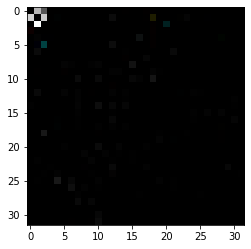

[8.340927124023438, 9.832611083984375, 9.325693130493164, 8.291356086730957, 35.56043243408203, 9.701152801513672, 8.051435470581055, 35.023258209228516, 9.127091407775879, 12.65707778930664]
14.591103553771973


In [22]:

# test_acc('models/1_ckpt.pth')
loss_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_troj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    print(loss["l1_loss"])
    loss_ls.append(loss["l1_loss"])
att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()
print(loss_ls)
print(np.mean(loss_ls))

#### benign

==> Preparing data..
Files already downloaded and verified
epoch 0
12.905109405517578 12.905109405517578 0.3433837890625
epoch 1
12.90230941772461 12.90230941772461 0.35329368710517883
epoch 2
12.899089813232422 12.899089813232422 0.3845583498477936
epoch 3
12.894864082336426 12.894864082336426 0.4398714601993561
epoch 4
12.889512062072754 12.889512062072754 0.5236988067626953
epoch 5
12.882046699523926 12.882046699523926 0.6432843208312988
epoch 6
12.871520042419434 12.871520042419434 0.8090430498123169
epoch 7
12.856663703918457 12.856663703918457 1.036755084991455
epoch 8
12.835838317871094 12.835838317871094 1.3484104871749878
epoch 9
12.806147575378418 12.806147575378418 1.775064468383789
epoch 10
12.763779640197754 12.763779640197754 2.3567490577697754
epoch 11
12.702260971069336 12.702260971069336 3.152975559234619
epoch 12
12.612295150756836 12.612295150756836 4.242429733276367
epoch 13
12.479540824890137 12.479540824890137 5.734659194946289
epoch 14
12.282301902770996 12.28230

epoch 30
1.041072964668274 0.010176470503211021 114.90886688232422
epoch 31
1.0678790807724 0.00959714874625206 111.56488037109375
epoch 32
0.8056323528289795 0.012158263474702835 106.47265625
epoch 33
0.5633478164672852 0.016758158802986145 101.59835815429688
epoch 34
0.437732994556427 0.021089723333716393 97.86891174316406
epoch 35
0.39899080991744995 0.022676721215248108 95.335693359375
epoch 36
0.40584540367126465 0.021773604676127434 93.62626647949219
epoch 37
0.4299633800983429 0.020076341927051544 92.29032135009766
epoch 38
0.4491698741912842 0.018811671063303947 90.95756530761719
epoch 39
0.45358288288116455 0.01825709640979767 89.47784423828125
epoch 40
0.4405362010002136 0.018443012610077858 87.84669494628906
epoch 41
0.4232400953769684 0.018843328580260277 86.20181274414062
epoch 42
0.4133303165435791 0.01892775483429432 84.65155029296875
epoch 43
0.4126177728176117 0.018578162416815758 83.20531463623047
epoch 44
0.41380372643470764 0.018146006390452385 81.79607391357422
epo

0.3168192207813263 0.016105037182569504 58.43013000488281
epoch 60
0.32664188742637634 0.015328582376241684 57.719913482666016
epoch 61
0.30775412917137146 0.016038376837968826 56.786468505859375
epoch 62
0.32153114676475525 0.015065870247781277 56.171653747558594
epoch 63
0.2957422733306885 0.01618274115025997 55.24039077758789
epoch 64
0.32748526334762573 0.014312755316495895 54.8236083984375
epoch 65
0.28388750553131104 0.016371767967939377 53.79705810546875
epoch 66
0.33086320757865906 0.013729152269661427 53.53981399536133
epoch 67
0.26268163323402405 0.017251890152692795 52.341270446777344
epoch 68
0.37746965885162354 0.011651202104985714 52.62224578857422
epoch 69
0.20650611817836761 0.02195674739778042 50.52104187011719
epoch 70
0.4708511531352997 0.009092745371162891 51.98651123046875
epoch 71
0.18419083952903748 0.02445613220334053 49.06492614746094
epoch 72
0.42987024784088135 0.009663316421210766 50.60592269897461
epoch 73
0.22539333999156952 0.01863512396812439 48.52964782

0.25457891821861267 0.012405999936163425 40.04397201538086
epoch 90
0.2670016884803772 0.011737346649169922 39.96125793457031
epoch 91
0.20287087559700012 0.01563427969813347 39.27309036254883
epoch 92
0.2546488046646118 0.01218851562589407 39.552310943603516
epoch 93
0.22853778302669525 0.013582407496869564 39.19611358642578
epoch 94
0.22611597180366516 0.013663023710250854 39.027496337890625
epoch 95
0.2459200918674469 0.012438459321856499 39.04151916503906
epoch 96
0.21524028480052948 0.014257971197366714 38.65599822998047
epoch 97
0.25935259461402893 0.011652817949652672 38.8640022277832
epoch 98
0.19396592676639557 0.015819652006030083 38.1821174621582
epoch 99
0.31343212723731995 0.00952419638633728 38.944786071777344
38.944786071777344
==> Preparing data..
Files already downloaded and verified
epoch 0
11.824505805969238 11.824505805969238 0.3433837890625
epoch 1
11.821489334106445 11.821489334106445 0.3549141585826874
epoch 2
11.818244934082031 11.818244934082031 0.3895257115364

8.391220092773438 8.390954971313477 32.27726745605469
epoch 20
7.5771098136901855 7.576725006103516 39.154754638671875
epoch 21
6.371384143829346 6.370813369750977 46.359031677246094
epoch 22
4.788784027099609 4.787852764129639 54.59526824951172
epoch 23
3.0255212783813477 3.0237340927124023 64.0361328125
epoch 24
1.4826810359954834 1.478325605392456 74.38677978515625
epoch 25
0.5878115892410278 0.5748722553253174 84.38455200195312
epoch 26
0.25209900736808777 0.21305035054683685 93.19327545166016
epoch 27
0.1961003541946411 0.0731297954916954 99.92811584472656
epoch 28
0.41753995418548584 0.023979678750038147 104.3744888305664
epoch 29
0.776655375957489 0.01256773341447115 106.02849578857422
epoch 30
0.9146902561187744 0.010462542995810509 104.60520935058594
epoch 31
0.7938811182975769 0.011648129671812057 101.1155014038086
epoch 32
0.6029257774353027 0.014807424508035183 97.08517456054688
epoch 33
0.46782928705215454 0.018597550690174103 93.54609680175781
epoch 34
0.40304046869277954

0.35267502069473267 0.015488925389945507 62.22650146484375
epoch 50
0.3471872806549072 0.015391882508993149 61.069549560546875
epoch 51
0.34373411536216736 0.015207034535706043 59.959224700927734
epoch 52
0.33124181628227234 0.015462299808859825 58.8267707824707
epoch 53
0.3203846514225006 0.015670480206608772 57.75017166137695
epoch 54
0.32011860609054565 0.01535494439303875 56.796287536621094
epoch 55
0.3170977532863617 0.015188603661954403 55.85578155517578
epoch 56
0.31104105710983276 0.015179195441305637 54.909446716308594
epoch 57
0.30560654401779175 0.015146477147936821 53.994468688964844
epoch 58
0.3082672357559204 0.014695397578179836 53.141544342041016
epoch 59
0.3008986711502075 0.014756263233721256 52.22392272949219
epoch 60
0.30071747303009033 0.014450514689087868 51.367042541503906
epoch 61
0.29012763500213623 0.014691323973238468 50.465240478515625
epoch 62
0.29286202788352966 0.014247222803533077 49.69487380981445
epoch 63
0.27657127380371094 0.014825426042079926 48.804

0.26600125432014465 0.01240360178053379 41.455238342285156
epoch 80
0.2946145534515381 0.010988905094563961 41.16735076904297
epoch 81
0.20060507953166962 0.01626473478972912 39.98246765136719
epoch 82
0.2799946367740631 0.011234300211071968 40.19334030151367
epoch 83
0.22732728719711304 0.013765173964202404 39.397193908691406
epoch 84
0.23771987855434418 0.012943332083523273 39.09357452392578
epoch 85
0.24096065759658813 0.012593570165336132 38.75956726074219
epoch 86
0.2228018343448639 0.013508089818060398 38.27158737182617
epoch 87
0.2493181824684143 0.011853274889290333 38.14736557006836
epoch 88
0.19992470741271973 0.014803297817707062 37.40407180786133
epoch 89
0.29457786679267883 0.009757173247635365 37.79044723510742
epoch 90
0.14289429783821106 0.021516168490052223 36.11592102050781
epoch 91
0.4785386919975281 0.005940433591604233 38.07438278198242
epoch 92
0.12181422114372253 0.026308562606573105 35.12616729736328
epoch 93
0.2848382294178009 0.00963892973959446 36.52626419067

11.635332107543945 11.635332107543945 1.7498867511749268
epoch 10
11.589908599853516 11.589908599853516 2.327974319458008
epoch 11
11.524103164672852 11.524103164672852 3.119680166244507
epoch 12
11.428132057189941 11.428132057189941 4.204143524169922
epoch 13
11.287492752075195 11.287492752075195 5.69246244430542
epoch 14
11.078797340393066 11.078797340393066 7.734771728515625
epoch 15
10.766327857971191 10.76632308959961 10.520423889160156
epoch 16
10.29117202758789 10.291130065917969 14.280753135681152
epoch 17
9.6377534866333 9.637657165527344 19.258512496948242
epoch 18
8.824776649475098 8.824600219726562 25.598228454589844
epoch 19
7.981047630310059 7.980757236480713 33.18484878540039
epoch 20
7.092340469360352 7.091907978057861 40.656166076660156
epoch 21
6.073644638061523 6.07302188873291 47.831851959228516
epoch 22
4.60722541809082 4.606260299682617 54.446136474609375
epoch 23
2.8276779651641846 2.825831890106201 62.16453170776367
epoch 24
1.488751769065857 1.4846028089523315 

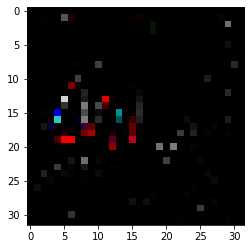

[40.704864501953125, 41.50813293457031, 39.292633056640625, 38.944786071777344, 42.56816482543945, 38.69157409667969, 32.913597106933594, 34.7572021484375, 42.745079040527344, 34.78417205810547]
38.69102058410645


In [23]:

# test_acc('models/1_ckpt.pth')
loss_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/benign' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    print(loss["l1_loss"])
    loss_ls.append(loss["l1_loss"])
att_inputs = mask * pattern
img = np.transpose(att_inputs,(1,2,0))
plt.imshow(img)
plt.show()
print(loss_ls)
print(np.mean(loss_ls))

### CODA 被reverse出来的asr小

#### 自身ASR

In [28]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_troj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/p_troj' + str(i) + '_checkpoint.pth')
    asr_ls.append(asr)
    print(asr_ls)
    print(np.mean(asr_ls))

==> Preparing data..
Files already downloaded and verified
epoch 0
10.051142692565918 10.051142692565918 0.3433837890625
epoch 1
10.048580169677734 10.048580169677734 0.3518627882003784
epoch 2
10.045663833618164 10.045663833618164 0.38149169087409973
epoch 3
10.042126655578613 10.042126655578613 0.4351196587085724
epoch 4
10.03747272491455 10.03747272491455 0.5162734985351562
epoch 5
10.030988693237305 10.030988693237305 0.6318106651306152
epoch 6
10.022253036499023 10.022253036499023 0.7922563552856445
epoch 7
10.009844779968262 10.009844779968262 1.012008786201477
epoch 8
9.992574691772461 9.992574691772461 1.3127858638763428
epoch 9
9.968046188354492 9.968046188354492 1.7221628427505493
epoch 10
9.933375358581543 9.933375358581543 2.2807133197784424
epoch 11
9.884208679199219 9.884208679199219 3.0372796058654785
epoch 12
9.813838958740234 9.813838958740234 4.062528133392334
epoch 13
9.713616371154785 9.713616371154785 5.450838088989258
epoch 14
9.569817543029785 9.569817543029785 7

epoch 20
6.515886306762695 6.5155720710754395 30.461193084716797
epoch 21
5.106671333312988 5.1061248779296875 37.9109992980957
epoch 22
3.7291080951690674 3.7281441688537598 45.936790466308594
epoch 23
2.44716739654541 2.445355176925659 54.31648254394531
epoch 24
1.4474432468414307 1.4437834024429321 62.83983612060547
epoch 25
0.7416189908981323 0.7332938313484192 71.04801177978516
epoch 26
0.39820605516433716 0.3801230192184448 78.73780822753906
epoch 27
0.24654260277748108 0.21069671213626862 85.526123046875
epoch 28
0.1869465410709381 0.11943411082029343 90.63288116455078
epoch 29
0.1910455822944641 0.0694407969713211 94.44332885742188
epoch 30
0.25537365674972534 0.040527261793613434 97.07135009765625
epoch 31
0.35323959589004517 0.02701166644692421 98.11959075927734
epoch 32
0.4381251037120819 0.020929722115397453 97.31782531738281
epoch 33
0.4625130295753479 0.01914163865149021 94.86854553222656
epoch 34
0.4351872503757477 0.019600041210651398 91.45526123046875
epoch 35
0.386508

epoch 50
0.31811821460723877 0.018454235047101974 65.30069732666016
epoch 51
0.3121678829193115 0.018376752734184265 63.98926544189453
epoch 52
0.3106548488140106 0.01802828535437584 62.755550384521484
epoch 53
0.3053445816040039 0.017924446612596512 61.51846694946289
epoch 54
0.3009333312511444 0.017764568328857422 60.30370330810547
epoch 55
0.297110378742218 0.017564568668603897 59.101009368896484
epoch 56
0.2933869957923889 0.01737237349152565 57.950286865234375
epoch 57
0.2860386371612549 0.017422214150428772 56.798919677734375
epoch 58
0.27764323353767395 0.017573943361639977 55.704429626464844
epoch 59
0.2781330943107605 0.01714446023106575 54.74509048461914
epoch 60
0.26934128999710083 0.017351383343338966 53.723731994628906
epoch 61
0.2563094198703766 0.017925791442394257 52.73215103149414
epoch 62
0.2631344795227051 0.01707875169813633 52.02324676513672
epoch 63
0.24485176801681519 0.018092123791575432 51.025634765625
epoch 64
0.2646182179450989 0.016328411176800728 50.5417785

epoch 79
0.24697627127170563 0.014092748984694481 42.8196907043457
epoch 80
0.1814650446176529 0.019380366429686546 41.41260528564453
epoch 81
0.2039070576429367 0.01682310178875923 41.473323822021484
epoch 82
0.20353807508945465 0.016672823578119278 41.15571212768555
epoch 83
0.18941788375377655 0.017848899587988853 40.62317657470703
epoch 84
0.20939867198467255 0.015837768092751503 40.655723571777344
epoch 85
0.1779758483171463 0.018744798377156258 39.8475341796875
epoch 86
0.2329711765050888 0.013883032836019993 40.41607666015625
epoch 87
0.14439287781715393 0.023742521181702614 38.64543533325195
epoch 88
0.33722394704818726 0.009494629688560963 41.11668395996094
epoch 89
0.13292710483074188 0.02602548338472843 37.82166290283203
epoch 90
0.23400823771953583 0.01331401988863945 39.383270263671875
epoch 91
0.19530822336673737 0.015925224870443344 38.56714630126953
epoch 92
0.15998129546642303 0.019793270155787468 37.7477912902832
epoch 93
0.23347347974777222 0.013005289249122143 38.67

Files already downloaded and verified
test acc: 95.90%
[99.7, 99.7, 95.0, 94.0, 95.89999999999999]
96.85999999999999
==> Preparing data..
Files already downloaded and verified
epoch 0
10.305883407592773 10.305883407592773 0.3433837890625
epoch 1
10.303253173828125 10.303253173828125 0.3465469479560852
epoch 2
10.300433158874512 10.300433158874512 0.3722928464412689
epoch 3
10.296896934509277 10.296896934509277 0.4223843514919281
epoch 4
10.292394638061523 10.292394638061523 0.4997897446155548
epoch 5
10.28619384765625 10.28619384765625 0.610966682434082
epoch 6
10.277626037597656 10.277626037597656 0.7657347917556763
epoch 7
10.265793800354004 10.265793800354004 0.978398859500885
epoch 8
10.249638557434082 10.249638557434082 1.2680895328521729
epoch 9
10.22719955444336 10.22719955444336 1.6622627973556519
epoch 10
10.19604778289795 10.19604778289795 2.1973443031311035
epoch 11
10.152546882629395 10.152546882629395 2.9229135513305664
epoch 12
10.090511322021484 10.090511322021484 3.9138

epoch 20
7.066131114959717 7.065817356109619 32.15979766845703
epoch 21
5.835779190063477 5.835296154022217 38.17337417602539
epoch 22
4.377993106842041 4.377202033996582 44.62055206298828
epoch 23
2.874000310897827 2.8725485801696777 51.70289611816406
epoch 24
1.6448709964752197 1.641843557357788 59.705299377441406
epoch 25
0.8503949642181396 0.843497633934021 68.17891693115234
epoch 26
0.40686842799186707 0.38987380266189575 76.25759887695312
epoch 27
0.21737565100193024 0.1757497638463974 83.15738677978516
epoch 28
0.18105453252792358 0.0721844956278801 88.5872802734375
epoch 29
0.27164411544799805 0.03467004746198654 92.15901184082031
epoch 30
0.37573397159576416 0.02376393973827362 93.64193725585938
epoch 31
0.43843749165534973 0.0198892243206501 93.24600219726562
epoch 32
0.4593607187271118 0.018482809886336327 91.48661804199219
epoch 33
0.44747841358184814 0.01839560456573963 88.932373046875
epoch 34
0.41342875361442566 0.019297568127512932 86.05773162841797
epoch 35
0.372417569

epoch 40
0.34853455424308777 0.020456407219171524 77.11299896240234
epoch 41
0.3474421799182892 0.020052216947078705 75.64894104003906
epoch 42
0.3438984155654907 0.019800610840320587 74.17333984375
epoch 43
0.33931124210357666 0.019613197073340416 72.7030029296875
epoch 44
0.33552873134613037 0.019379759207367897 71.26890563964844
epoch 45
0.33268994092941284 0.01909061335027218 69.86802673339844
epoch 46
0.3316957950592041 0.01869497448205948 68.51542663574219
epoch 47
0.32961755990982056 0.01836632937192917 67.16542053222656
epoch 48
0.3249778151512146 0.01819109171628952 65.80784606933594
epoch 49
0.3175130784511566 0.018192840740084648 64.45484924316406
epoch 50
0.31450217962265015 0.017938118427991867 63.19801330566406
epoch 51
0.31739434599876404 0.017338894307613373 62.02629089355469
epoch 52
0.3177192509174347 0.01689821109175682 60.833370208740234
epoch 53
0.31581181287765503 0.016588371247053146 59.63629150390625
epoch 54
0.30255869030952454 0.01692895218729973 58.3541221618

epoch 70
0.17940884828567505 0.016678160056471825 37.14048385620117
epoch 71
0.20444674789905548 0.014196187257766724 37.008323669433594
epoch 72
0.16940158605575562 0.017041541635990143 35.964500427246094
epoch 73
0.19982807338237762 0.013957398943603039 35.942710876464844
epoch 74
0.1547481119632721 0.018129421398043633 34.7681770324707
epoch 75
0.20137089490890503 0.013323557563126087 35.05459213256836
epoch 76
0.1477273404598236 0.01839098334312439 33.78622817993164
epoch 77
0.18898355960845947 0.013747275806963444 34.090213775634766
epoch 78
0.15211716294288635 0.017114290967583656 33.10478210449219
epoch 79
0.17057012021541595 0.01482296921312809 33.08634948730469
epoch 80
0.15786117315292358 0.01584753580391407 32.50566101074219
epoch 81
0.16241174936294556 0.015095407143235207 32.237998962402344
epoch 82
0.15581609308719635 0.015536103397607803 31.794044494628906
epoch 83
0.16152241826057434 0.014676817692816257 31.55225944519043
epoch 84
0.14536795020103455 0.01619621366262436

0.0026012358721345663 0.002186752622947097 10.009063720703125
==> Preparing data..
Files already downloaded and verified
test acc: 99.70%
[99.7, 99.7, 95.0, 94.0, 95.89999999999999, 99.9, 99.9, 95.8, 92.2, 99.7]
97.18


In [29]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    asr_ls.append(asr)
    print(asr_ls)
    print(np.mean(asr_ls))

==> Preparing data..
Files already downloaded and verified
epoch 0
9.328863143920898 9.328863143920898 0.3433837890625
epoch 1
9.32645320892334 9.32645320892334 0.3465971350669861
epoch 2
9.323531150817871 9.323531150817871 0.37299996614456177
epoch 3
9.320306777954102 9.320306777954102 0.4233678877353668
epoch 4
9.31587028503418 9.31587028503418 0.5012785196304321
epoch 5
9.310042381286621 9.310042381286621 0.6129741072654724
epoch 6
9.301977157592773 9.301977157592773 0.7684760093688965
epoch 7
9.29071044921875 9.29071044921875 0.9828752279281616
epoch 8
9.275150299072266 9.275150299072266 1.275740623474121
epoch 9
9.253493309020996 9.253493309020996 1.6744521856307983
epoch 10
9.223221778869629 9.223221778869629 2.2179808616638184
epoch 11
9.180543899536133 9.180543899536133 2.9598989486694336
epoch 12
9.119068145751953 9.119068145751953 3.967388153076172
epoch 13
9.031644821166992 9.031644821166992 5.330233097076416
epoch 14
8.90686321258545 8.90686321258545 7.155345916748047
epoch

epoch 30
0.5403698682785034 0.017871776595711708 103.37968444824219
epoch 31
0.6360427737236023 0.014860155992209911 102.30870056152344
epoch 32
0.6360065340995789 0.014441165141761303 99.76126861572266
epoch 33
0.5732780694961548 0.015510572120547295 96.51292419433594
epoch 34
0.4935869574546814 0.017478395253419876 93.21612548828125
epoch 35
0.43300262093544006 0.019410347566008568 90.27969360351562
epoch 36
0.397540807723999 0.020651042461395264 87.8316650390625
epoch 37
0.3793862462043762 0.021165359765291214 85.81873321533203
epoch 38
0.3714579939842224 0.021163037046790123 84.13304138183594
epoch 39
0.36914515495300293 0.020861007273197174 82.65557861328125
epoch 40
0.36854124069213867 0.020482545718550682 81.2912826538086
epoch 41
0.36675727367401123 0.020192548632621765 79.9802474975586
epoch 42
0.3650621175765991 0.01990404911339283 78.70042419433594
epoch 43
0.3656148314476013 0.01949298568069935 77.469482421875
epoch 44
0.36526021361351013 0.019138745963573456 76.24330139160

0.2442019134759903 0.01581108756363392 46.11106872558594
epoch 60
0.24858206510543823 0.015198498032987118 45.470794677734375
epoch 61
0.23758280277252197 0.015635589137673378 44.70275115966797
epoch 62
0.24336004257202148 0.014946834184229374 44.140541076660156
epoch 63
0.2189667820930481 0.016424210742115974 43.266014099121094
epoch 64
0.2552661895751953 0.013701777905225754 43.09861755371094
epoch 65
0.19983914494514465 0.017484720796346664 41.884159088134766
epoch 66
0.27249953150749207 0.012337314896285534 42.09702682495117
epoch 67
0.18009105324745178 0.018909312784671783 40.478355407714844
epoch 68
0.29438456892967224 0.010976637713611126 41.10865783691406
epoch 69
0.16929829120635986 0.019481753930449486 39.186885833740234
epoch 70
0.2838766574859619 0.010938196443021297 39.85454177856445
epoch 71
0.1738821566104889 0.01807386800646782 38.16058349609375
epoch 72
0.2549076974391937 0.01173703745007515 38.54103088378906
epoch 73
0.1754121482372284 0.017198504880070686 37.21038055

0.14717264473438263 0.02156182751059532 37.083984375
epoch 88
0.24124373495578766 0.012297892943024635 38.15550994873047
epoch 89
0.18724627792835236 0.015869801864027977 37.197105407714844
epoch 90
0.18482546508312225 0.015961144119501114 36.95267868041992
epoch 91
0.22169579565525055 0.013015130534768105 37.16006088256836
epoch 92
0.16021233797073364 0.01845625787973404 36.16286849975586
epoch 93
0.26548075675964355 0.010684967041015625 37.22484588623047
epoch 94
0.13103751838207245 0.023487627506256104 35.26091766357422
epoch 95
0.3236618936061859 0.008726648986339569 37.48329162597656
epoch 96
0.14583240449428558 0.020040076225996017 35.20887756347656
epoch 97
0.1886662095785141 0.014769521541893482 35.68370819091797
epoch 98
0.2128048539161682 0.012893591076135635 35.77573776245117
epoch 99
0.1574908047914505 0.017807617783546448 34.874244689941406
==> Preparing data..
Files already downloaded and verified
test acc: 88.50%
[94.3, 87.0, 89.3, 88.5]
89.775
==> Preparing data..
Files

epoch 10
11.062178611755371 11.062178611755371 2.376833915710449
epoch 11
10.980193138122559 10.980193138122559 3.1843838691711426
epoch 12
10.857260704040527 10.857260704040527 4.293399810791016
epoch 13
10.675939559936523 10.675939559936523 5.805724143981934
epoch 14
10.414834976196289 10.414834976196289 7.843845367431641
epoch 15
10.050403594970703 10.050397872924805 10.559118270874023
epoch 16
9.583211898803711 9.583168983459473 14.146371841430664
epoch 17
9.076279640197754 9.076184272766113 18.675981521606445
epoch 18
8.54590892791748 8.545747756958008 23.749805450439453
epoch 19
7.981181621551514 7.980947971343994 28.638168334960938
epoch 20
7.225785732269287 7.225466251373291 33.09881591796875
epoch 21
6.054875373840332 6.05441427230835 37.90343475341797
epoch 22
4.523275852203369 4.522518634796143 44.24454879760742
epoch 23
2.8218841552734375 2.8203744888305664 52.57948303222656
epoch 24
1.443871021270752 1.4402445554733276 62.230186462402344
epoch 25
0.5810670256614685 0.57020

epoch 40
0.3907022178173065 0.016724174842238426 72.54473876953125
epoch 41
0.3910888135433197 0.016325918957591057 71.18347930908203
epoch 42
0.3916712701320648 0.01593131013214588 69.86029052734375
epoch 43
0.3884967863559723 0.015696818009018898 68.51773071289062
epoch 44
0.38153818249702454 0.015617595985531807 67.14799499511719
epoch 45
0.3699645698070526 0.01574471779167652 65.77091217041016
epoch 46
0.35529088973999023 0.016048075631260872 64.44194030761719
epoch 47
0.3499795198440552 0.01594541035592556 63.26310729980469
epoch 48
0.35039806365966797 0.015580082312226295 62.16490936279297
epoch 49
0.3487876057624817 0.015317941084504128 61.08068084716797
epoch 50
0.34565263986587524 0.015128182247281075 60.00233840942383
epoch 51
0.33411866426467896 0.01533607766032219 58.88874435424805
epoch 52
0.32489123940467834 0.01546009536832571 57.83834457397461
epoch 53
0.32549944519996643 0.015110986307263374 56.902748107910156
epoch 54
0.3261245787143707 0.014771983958780766 55.9929504

0.2630348801612854 0.014579271897673607 46.22301483154297
epoch 70
0.2102428376674652 0.018217958509922028 44.983009338378906
epoch 71
0.23046790063381195 0.016239946708083153 44.790504455566406
epoch 72
0.21910922229290009 0.016897816210985184 44.1693115234375
epoch 73
0.2244761884212494 0.016230056062340736 43.7984619140625
epoch 74
0.21279370784759521 0.016962900757789612 43.21858215332031
epoch 75
0.2276625633239746 0.01556440256536007 43.011810302734375
epoch 76
0.191144660115242 0.018598021939396858 42.09025955200195
epoch 77
0.26559802889823914 0.01295690517872572 42.734466552734375
epoch 78
0.14499343931674957 0.025553148239850998 40.520751953125
epoch 79
0.3609867990016937 0.009436607360839844 43.17440414428711
epoch 80
0.18346072733402252 0.018503254279494286 40.522499084472656
epoch 81
0.1562807559967041 0.02216693013906479 39.728912353515625
epoch 82
0.2823304235935211 0.011558362282812595 41.29681396484375
epoch 83
0.1870923787355423 0.017533810809254646 39.73007583618164


0.14086267352104187 0.02469538152217865 38.687957763671875
==> Preparing data..
Files already downloaded and verified
test acc: 96.30%
[94.3, 87.0, 89.3, 88.5, 93.30000000000001, 92.0, 91.60000000000001, 86.2, 96.3]
90.94444444444444
==> Preparing data..
Files already downloaded and verified
epoch 0
9.956596374511719 9.956596374511719 0.3433837890625
epoch 1
9.954025268554688 9.954025268554688 0.3534269332885742
epoch 2
9.95117473602295 9.95117473602295 0.3861108422279358
epoch 3
9.947792053222656 9.947792053222656 0.4440212845802307
epoch 4
9.943195343017578 9.943195343017578 0.5309126973152161
epoch 5
9.936799049377441 9.936799049377441 0.6540658473968506
epoch 6
9.928315162658691 9.928315162658691 0.824484646320343
epoch 7
9.916597366333008 9.916597366333008 1.0571905374526978
epoch 8
9.9005708694458 9.9005708694458 1.3722262382507324
epoch 9
9.878528594970703 9.878528594970703 1.7983779907226562
epoch 10
9.848628997802734 9.848628997802734 2.374560832977295
epoch 11
9.8077440261840

In [30]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/benign' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/benign' + str(i) + '_checkpoint.pth')
    asr_ls.append(asr)
    print(asr_ls)
    print(np.mean(asr_ls))

==> Preparing data..
Files already downloaded and verified
epoch 0
12.804479598999023 12.804479598999023 0.3433837890625
epoch 1
12.801421165466309 12.801421165466309 0.35101592540740967
epoch 2
12.797826766967773 12.797826766967773 0.382676362991333
epoch 3
12.793317794799805 12.793317794799805 0.43953606486320496
epoch 4
12.787281036376953 12.787281036376953 0.5252960920333862
epoch 5
12.778964042663574 12.778964042663574 0.6471304893493652
epoch 6
12.767197608947754 12.767197608947754 0.8159521818161011
epoch 7
12.750720024108887 12.750720024108887 1.0474406480789185
epoch 8
12.727097511291504 12.727097511291504 1.3641551733016968
epoch 9
12.693840026855469 12.693840026855469 1.7966915369033813
epoch 10
12.645879745483398 12.645879745483398 2.388911008834839
epoch 11
12.576434135437012 12.576434135437012 3.2000467777252197
epoch 12
12.47404670715332 12.47404670715332 4.310097694396973
epoch 13
12.323450088500977 12.323450088500977 5.8338823318481445
epoch 14
12.104092597961426 12.10

epoch 30
1.0025272369384766 0.010264839045703411 111.8541259765625
epoch 31
1.006822943687439 0.009849797934293747 108.19983673095703
epoch 32
0.7245526313781738 0.013072168454527855 103.00591278076172
epoch 33
0.5153201222419739 0.017741618677973747 98.27847290039062
epoch 34
0.4230496287345886 0.021080734208226204 94.73798370361328
epoch 35
0.40871480107307434 0.021234875544905663 92.28087615966797
epoch 36
0.4265482425689697 0.019775204360485077 90.440185546875
epoch 37
0.4477876126766205 0.01834065094590187 88.76336669921875
epoch 38
0.45458507537841797 0.017621254548430443 86.99850463867188
epoch 39
0.44555163383483887 0.01754719577729702 85.10277557373047
epoch 40
0.4311935305595398 0.017695961520075798 83.17237091064453
epoch 41
0.42369505763053894 0.01755782775580883 81.30886840820312
epoch 42
0.4221992492675781 0.01716241054236889 79.51408386230469
epoch 43
0.4229501187801361 0.01667780801653862 77.75730895996094
epoch 44
0.42273131012916565 0.01623421721160412 75.991615295410

0.36790746450424194 0.012691754847764969 55.08310317993164
epoch 60
0.30495893955230713 0.015116650611162186 53.81443786621094
epoch 61
0.3869638442993164 0.011587351560592651 53.496192932128906
epoch 62
0.24323907494544983 0.018583238124847412 51.74832534790039
epoch 63
0.44527751207351685 0.009730619378387928 52.38140869140625
epoch 64
0.21379615366458893 0.020779365673661232 50.10765838623047
epoch 65
0.38568931818008423 0.01089707762002945 50.841400146484375
epoch 66
0.2599310278892517 0.016157735139131546 49.38823699951172
epoch 67
0.2978670597076416 0.013777063228189945 49.139251708984375
epoch 68
0.29186326265335083 0.013873351737856865 48.5665168762207
epoch 69
0.27169522643089294 0.01474962942302227 47.898521423339844
epoch 70
0.30370062589645386 0.012944351881742477 47.636512756347656
epoch 71
0.2448672503232956 0.016033049672842026 46.6890983581543
epoch 72
0.35647764801979065 0.010702021420001984 47.00497817993164
epoch 73
0.1744498908519745 0.02310527116060257 44.968578338

0.2507920265197754 0.009890527464449406 33.8264274597168
epoch 90
0.17723074555397034 0.01412401907145977 33.03722381591797
epoch 91
0.21085716784000397 0.01159616932272911 33.10663986206055
epoch 92
0.19788102805614471 0.012283142656087875 32.7972526550293
epoch 93
0.20020869374275208 0.012007378041744232 32.59804153442383
epoch 94
0.1973484456539154 0.012069706805050373 32.36260223388672
epoch 95
0.20150558650493622 0.011684354394674301 32.17938232421875
epoch 96
0.19247782230377197 0.012137165293097496 31.888240814208984
epoch 97
0.210849329829216 0.010904664173722267 31.80329132080078
epoch 98
0.1697559356689453 0.013611226342618465 31.25320816040039
epoch 99
0.3177691102027893 0.007053922861814499 31.91761016845703
==> Preparing data..
Files already downloaded and verified
test acc: 84.30%
[90.3, 86.0, 86.8, 84.3]
86.85000000000001
==> Preparing data..
Files already downloaded and verified
epoch 0
11.221634864807129 11.221634864807129 0.3433837890625
epoch 1
11.218606948852539 11.

epoch 10
11.30085563659668 11.30085563659668 2.4198036193847656
epoch 11
11.240287780761719 11.240287780761719 3.232872486114502
epoch 12
11.155237197875977 11.155237197875977 4.341416358947754
epoch 13
11.035540580749512 11.035540580749512 5.843029499053955
epoch 14
10.867382049560547 10.867382049560547 7.879312038421631
epoch 15
10.633806228637695 10.633800506591797 10.611522674560547
epoch 16
10.311186790466309 10.311145782470703 14.217652320861816
epoch 17
9.872373580932617 9.872282981872559 18.9229736328125
epoch 18
9.313819885253906 9.31365966796875 24.88943099975586
epoch 19
8.655265808105469 8.655011177062988 32.016090393066406
epoch 20
7.916418552398682 7.916041851043701 39.812705993652344
epoch 21
7.029181480407715 7.0286431312561035 47.85475540161133
epoch 22
5.843676567077637 5.8428955078125 55.63735580444336
epoch 23
4.335557460784912 4.334322452545166 63.53777313232422
epoch 24
2.8245675563812256 2.8223538398742676 72.47931671142578
epoch 25
1.59272301197052 1.58817851543

0.41386768221855164 0.016291910782456398 74.77268981933594
epoch 40
0.4073777496814728 0.016174759715795517 73.27613830566406
epoch 41
0.4068242013454437 0.015822041779756546 71.86451721191406
epoch 42
0.4052843153476715 0.015516017563641071 70.47651672363281
epoch 43
0.39921846985816956 0.015390712767839432 69.07382202148438
epoch 44
0.3876393139362335 0.015495645813643932 67.66606140136719
epoch 45
0.38228490948677063 0.015354493632912636 66.34030151367188
epoch 46
0.37889209389686584 0.015139268711209297 65.06951141357422
epoch 47
0.37812352180480957 0.014814013615250587 63.820716857910156
epoch 48
0.3692972958087921 0.014820308424532413 62.534584045410156
epoch 49
0.36201146245002747 0.014772376976907253 61.29546356201172
epoch 50
0.3605089485645294 0.014490196481347084 60.1387939453125
epoch 51
0.35358044505119324 0.014447596855461597 58.996543884277344
epoch 52
0.34841179847717285 0.014342010021209717 57.91231918334961
epoch 53
0.3496665954589844 0.01396714523434639 56.8876228332

0.23294807970523834 0.016334587708115578 45.38291931152344
epoch 70
0.31052741408348083 0.01180468313395977 45.26327133178711
epoch 71
0.2702831029891968 0.013385679572820663 44.3874626159668
epoch 72
0.2742197811603546 0.01294776052236557 43.82887268066406
epoch 73
0.2712627053260803 0.012872301042079926 43.26078796386719
epoch 74
0.2600729167461395 0.013231147080659866 42.659996032714844
epoch 75
0.2711876928806305 0.012456301599740982 42.228363037109375
epoch 76
0.23996827006340027 0.013944903388619423 41.51873779296875
epoch 77
0.30231648683547974 0.010788855142891407 41.452491760253906
epoch 78
0.1818806231021881 0.018359364941716194 40.021461486816406
epoch 79
0.48769956827163696 0.006530734244734049 41.42385482788086
epoch 80
0.11445920169353485 0.035428594797849655 37.999427795410156
epoch 81
0.5826979875564575 0.005362398456782103 40.95903396606445
epoch 82
0.2187078595161438 0.013984263874590397 38.629085540771484
epoch 83
0.15254101157188416 0.02094940096139908 37.5676536560

0.7987703084945679 0.004537814296782017 46.040794372558594
==> Preparing data..
Files already downloaded and verified
test acc: 86.80%
[90.3, 86.0, 86.8, 84.3, 88.3, 91.4, 87.4, 89.1, 86.8]
87.82222222222221
==> Preparing data..
Files already downloaded and verified
epoch 0
11.476171493530273 11.476171493530273 0.3433837890625
epoch 1
11.472933769226074 11.472933769226074 0.35173389315605164
epoch 2
11.469112396240234 11.469112396240234 0.3831530213356018
epoch 3
11.464261054992676 11.464261054992676 0.4393937885761261
epoch 4
11.457732200622559 11.457732200622559 0.524388313293457
epoch 5
11.448829650878906 11.448829650878906 0.6454435586929321
epoch 6
11.436302185058594 11.436302185058594 0.8134909868240356
epoch 7
11.418449401855469 11.418449401855469 1.0445873737335205
epoch 8
11.393204689025879 11.393204689025879 1.3613545894622803
epoch 9
11.357492446899414 11.357492446899414 1.7941787242889404
epoch 10
11.30643081665039 11.30643081665039 2.386200428009033
epoch 11
11.23282623291

#### 同类别model的平均ASR

In [ ]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_troj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    for j in range(10):
        asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/p_troj' + str(j) + '_checkpoint.pth')
        asr_ls.append(asr)
    
print(asr_ls)
print(np.mean(asr_ls))


In [32]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    for j in range(10):
        asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/p_advtroj' + str(j) + '_checkpoint.pth')
        asr_ls.append(asr)
    
print(asr_ls)
print(np.mean(asr_ls))


==> Preparing data..
Files already downloaded and verified
epoch 0
9.302287101745605 9.302287101745605 0.3433837890625
epoch 1
9.299596786499023 9.299596786499023 0.3491436541080475
epoch 2
9.296512603759766 9.296512603759766 0.37593573331832886
epoch 3
9.29295539855957 9.29295539855957 0.4267680048942566
epoch 4
9.288222312927246 9.288222312927246 0.5055557489395142
epoch 5
9.281700134277344 9.281700134277344 0.6187081336975098
epoch 6
9.272823333740234 9.272823333740234 0.77588951587677
epoch 7
9.26050090789795 9.26050090789795 0.9916998744010925
epoch 8
9.243138313293457 9.243138313293457 1.287017822265625
epoch 9
9.219132423400879 9.219132423400879 1.6895307302474976
epoch 10
9.185077667236328 9.185077667236328 2.2395682334899902
epoch 11
9.136631965637207 9.136631965637207 2.9925975799560547
epoch 12
9.068255424499512 9.068255424499512 4.01779842376709
epoch 13
8.969627380371094 8.969627380371094 5.401486873626709
epoch 14
8.827908515930176 8.827908515930176 7.261846542358398
epoc

7.648462772369385 7.648169040679932 32.47190475463867
epoch 20
6.872128009796143 6.871699333190918 39.443092346191406
epoch 21
5.760077476501465 5.7594757080078125 44.66399002075195
epoch 22
4.570715427398682 4.569843292236328 49.845863342285156
epoch 23
3.3910746574401855 3.3897316455841064 55.526451110839844
epoch 24
2.179698944091797 2.1773061752319336 62.09865951538086
epoch 25
1.0973209142684937 1.0917831659317017 70.4596939086914
epoch 26
0.4405246376991272 0.4242713153362274 78.95823669433594
epoch 27
0.2180364727973938 0.17414915561676025 86.42938232421875
epoch 28
0.18104338645935059 0.09272296726703644 91.89330291748047
epoch 29
0.20891068875789642 0.055877670645713806 95.51128387451172
epoch 30
0.2764859199523926 0.03641720116138458 97.42630004882812
epoch 31
0.37362679839134216 0.02524496242403984 97.94886779785156
epoch 32
0.46533530950546265 0.019567945972085 97.22750854492188
epoch 33
0.5210698246955872 0.016941606998443604 95.40740966796875
epoch 34
0.5281158685684204 0

0.33682698011398315 0.018791306763887405 69.76305389404297
epoch 40
0.32596927881240845 0.01894002966582775 68.15142822265625
epoch 41
0.3163684606552124 0.01903809979557991 66.60604858398438
epoch 42
0.309775710105896 0.018970990553498268 65.16853332519531
epoch 43
0.3042367398738861 0.018857907503843307 63.81647491455078
epoch 44
0.2997957468032837 0.018687250092625618 62.53144836425781
epoch 45
0.29480043053627014 0.018567616119980812 61.28984832763672
epoch 46
0.29180219769477844 0.018315233290195465 60.08977508544922
epoch 47
0.28817516565322876 0.01810593530535698 58.8985595703125
epoch 48
0.2842230796813965 0.017926571890711784 57.737831115722656
epoch 49
0.2813377380371094 0.017681658267974854 56.61876678466797
epoch 50
0.2802684009075165 0.017312517389655113 55.52427673339844
epoch 51
0.2768898010253906 0.017094392329454422 54.41044235229492
epoch 52
0.26887843012809753 0.017197471112012863 53.28276062011719
epoch 53
0.26344913244247437 0.01714939810335636 52.23891830444336
ep

epoch 59
0.2988010346889496 0.014712321572005749 51.796043395996094
epoch 60
0.33131173253059387 0.012930226512253284 51.167449951171875
epoch 61
0.2607942223548889 0.016285914927721024 49.820411682128906
epoch 62
0.3815435767173767 0.010766467079520226 49.91958999633789
epoch 63
0.1874549686908722 0.022867856547236443 47.637542724609375
epoch 64
0.5163387656211853 0.007739539723843336 49.36323547363281
epoch 65
0.19616878032684326 0.020705562084913254 46.33064651489258
epoch 66
0.28218355774879456 0.013591899536550045 46.50670623779297
epoch 67
0.30509787797927856 0.01231735572218895 46.06281661987305
epoch 68
0.22278311848640442 0.016901299357414246 44.79669952392578
epoch 69
0.3194723129272461 0.011358954012393951 44.998451232910156
epoch 70
0.21692118048667908 0.016796203330159187 43.61339569091797
epoch 71
0.31529501080513 0.011134547181427479 43.86688995361328
epoch 72
0.20422887802124023 0.017330657690763474 42.390689849853516
epoch 73
0.339495450258255 0.009987651370465755 42.9

0.14548666775226593 0.022849012166261673 38.02149200439453
epoch 80
0.3659048080444336 0.0083618788048625 39.89730453491211
epoch 81
0.14507417380809784 0.022391552105545998 37.470542907714844
epoch 82
0.28231164813041687 0.010579603724181652 38.7481689453125
epoch 83
0.19091157615184784 0.01577729545533657 37.63145065307617
epoch 84
0.20918264985084534 0.014144507236778736 37.587181091308594
epoch 85
0.22815996408462524 0.01278478279709816 37.535247802734375
epoch 86
0.18724645674228668 0.015673261135816574 36.89111328125
epoch 87
0.2659178674221039 0.010725094936788082 37.369667053222656
epoch 88
0.14335188269615173 0.02115079201757908 35.84649658203125
epoch 89
0.4359571933746338 0.006506624165922403 37.94273376464844
epoch 90
0.10602936148643494 0.03407294675707817 34.517669677734375
epoch 91
0.42276304960250854 0.00659905793145299 37.46289825439453
epoch 92
0.20448891818523407 0.01345739234238863 35.707862854003906
epoch 93
0.1374255269765854 0.021196909248828888 34.63687133789062

0.17559264600276947 0.01710921712219715 37.115272521972656
==> Preparing data..
Files already downloaded and verified
test acc: 29.90%
==> Preparing data..
Files already downloaded and verified
test acc: 16.90%
==> Preparing data..
Files already downloaded and verified
test acc: 40.80%
==> Preparing data..
Files already downloaded and verified
test acc: 42.50%
==> Preparing data..
Files already downloaded and verified
test acc: 51.30%
==> Preparing data..
Files already downloaded and verified
test acc: 94.70%
==> Preparing data..
Files already downloaded and verified
test acc: 22.30%
==> Preparing data..
Files already downloaded and verified
test acc: 27.20%
==> Preparing data..
Files already downloaded and verified
test acc: 10.30%
==> Preparing data..
Files already downloaded and verified
test acc: 6.00%
==> Preparing data..
Files already downloaded and verified
epoch 0
9.782061576843262 9.782061576843262 0.3433837890625
epoch 1
9.77967643737793 9.77967643737793 0.34984391927719116
e

test acc: 43.90%
==> Preparing data..
Files already downloaded and verified
epoch 0
10.047313690185547 10.047313690185547 0.3433837890625
epoch 1
10.044595718383789 10.044595718383789 0.34769734740257263
epoch 2
10.041632652282715 10.041632652282715 0.37517523765563965
epoch 3
10.037917137145996 10.037917137145996 0.4265150725841522
epoch 4
10.033058166503906 10.033058166503906 0.5052881240844727
epoch 5
10.026559829711914 10.026559829711914 0.6176940202713013
epoch 6
10.017644882202148 10.017644882202148 0.7740419507026672
epoch 7
10.00532054901123 10.00532054901123 0.9884704351425171
epoch 8
9.988295555114746 9.988295555114746 1.280981183052063
epoch 9
9.964877128601074 9.964877128601074 1.6769343614578247
epoch 10
9.932140350341797 9.932140350341797 2.2144455909729004
epoch 11
9.886146545410156 9.886146545410156 2.9413225650787354
epoch 12
9.821625709533691 9.821625709533691 3.922227621078491
epoch 13
9.729454040527344 9.729454040527344 5.254776477813721
epoch 14
9.596238136291504 9

7.482804298400879 7.482559680938721 28.32146453857422
epoch 20
6.742796897888184 6.742435932159424 34.35096740722656
epoch 21
5.819967269897461 5.8194355964660645 40.9383544921875
epoch 22
4.771927356719971 4.771123886108398 48.32825469970703
epoch 23
3.6538290977478027 3.6525516510009766 56.66234588623047
epoch 24
2.499751329421997 2.497518539428711 65.76551818847656
epoch 25
1.4256772994995117 1.4210532903671265 75.70881652832031
epoch 26
0.6526689529418945 0.6407701969146729 86.24356079101562
epoch 27
0.2946845293045044 0.2616816759109497 96.3624267578125
epoch 28
0.199785515666008 0.12230086326599121 104.76439666748047
epoch 29
0.22261711955070496 0.06307058036327362 110.62691497802734
epoch 30
0.3765130043029785 0.03007538989186287 114.19245147705078
epoch 31
0.7700595855712891 0.013891154900193214 115.04051208496094
epoch 32
0.9010066390037537 0.011452753096818924 111.87841796875
epoch 33
0.7159005999565125 0.013713077642023563 106.29151916503906
epoch 34
0.5069392323493958 0.018

epoch 39
0.4688153862953186 0.023734373971819878 115.63719177246094
epoch 40
0.4266521632671356 0.025237908586859703 111.30855560302734
epoch 41
0.3964728116989136 0.026316070929169655 107.41071319580078
epoch 42
0.3889457881450653 0.025920027866959572 104.09637451171875
epoch 43
0.39609286189079285 0.024531297385692596 101.14886474609375
epoch 44
0.39773255586624146 0.02358468621969223 98.24159240722656
epoch 45
0.3848690688610077 0.02359660714864731 95.24803924560547
epoch 46
0.36535942554473877 0.024133319035172462 92.34917449951172
epoch 47
0.34684106707572937 0.024735288694500923 89.67378234863281
epoch 48
0.3358367383480072 0.024867262691259384 87.32958984375
epoch 49
0.33138105273246765 0.02451273985207081 85.22183227539062
epoch 50
0.33104461431503296 0.023835107684135437 83.22371673583984
epoch 51
0.3293071985244751 0.02326543629169464 81.20195007324219
epoch 52
0.32408034801483154 0.022973468527197838 79.17469024658203
epoch 53
0.3169955313205719 0.022835662588477135 77.17333

In [33]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/benign' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    for j in range(10):
        asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/benign' + str(j) + '_checkpoint.pth')
        asr_ls.append(asr)
    
print(asr_ls)
print(np.mean(asr_ls))


==> Preparing data..
Files already downloaded and verified
epoch 0
12.318105697631836 12.318105697631836 0.3433837890625
epoch 1
12.314988136291504 12.314988136291504 0.3544648289680481
epoch 2
12.311437606811523 12.311437606811523 0.3886513113975525
epoch 3
12.306787490844727 12.306787490844727 0.4479612410068512
epoch 4
12.300694465637207 12.300694465637207 0.5366013050079346
epoch 5
12.292025566101074 12.292025566101074 0.6620732545852661
epoch 6
12.28024673461914 12.28024673461914 0.8353168368339539
epoch 7
12.263505935668945 12.263505935668945 1.0731240510940552
epoch 8
12.239252090454102 12.239252090454102 1.3986841440200806
epoch 9
12.204965591430664 12.204965591430664 1.844266653060913
epoch 10
12.155339241027832 12.155339241027832 2.454524517059326
epoch 11
12.082707405090332 12.082707405090332 3.290619134902954
epoch 12
11.97677993774414 11.97677993774414 4.438169479370117
epoch 13
11.817907333374023 11.817907333374023 6.013676166534424
epoch 14
11.582480430603027 11.58248043

8.021269798278809 8.02098560333252 32.77853012084961
epoch 20
6.993650913238525 6.993203639984131 41.29136657714844
epoch 21
5.747534275054932 5.74683952331543 49.937538146972656
epoch 22
4.13614559173584 4.1349873542785645 57.89070129394531
epoch 23
2.446251392364502 2.443943977355957 66.3935546875
epoch 24
1.2072290182113647 1.2016724348068237 76.77217864990234
epoch 25
0.46960219740867615 0.4524821937084198 87.46490478515625
epoch 26
0.19661292433738708 0.1296374350786209 96.82530212402344
epoch 27
0.28816109895706177 0.03729233890771866 103.55482482910156
epoch 28
0.7076461911201477 0.014009497128427029 107.17500305175781
epoch 29
1.0309396982192993 0.009491396136581898 106.94969177246094
epoch 30
0.9789722561836243 0.009648812003433704 103.52819061279297
epoch 31
0.7521513104438782 0.01200331375002861 98.84227752685547
epoch 32
0.5615625977516174 0.015456604771316051 94.40943908691406
epoch 33
0.45579713582992554 0.018486041575670242 90.84150695800781
epoch 34
0.411971777677536 0.

0.5246312618255615 0.01292243879288435 76.12525177001953
epoch 40
0.494612455368042 0.013383426703512669 74.40493774414062
epoch 41
0.4547897279262543 0.0142283383756876 72.68456268310547
epoch 42
0.43384358286857605 0.01458385493606329 71.14422607421875
epoch 43
0.43408745527267456 0.014243855141103268 69.80191040039062
epoch 44
0.43603378534317017 0.013865966349840164 68.53764343261719
epoch 45
0.42895153164863586 0.013795578852295876 67.27316284179688
epoch 46
0.4179481267929077 0.013861868530511856 66.01390075683594
epoch 47
0.40973085165023804 0.013843175023794174 64.80342102050781
epoch 48
0.4051796495914459 0.01370312925428152 63.64453125
epoch 49
0.3990190625190735 0.013626519590616226 62.51558303833008
epoch 50
0.38800886273384094 0.013727220706641674 61.37845993041992
epoch 51
0.37918582558631897 0.013761119917035103 60.286529541015625
epoch 52
0.37147819995880127 0.013770243152976036 59.25724792480469
epoch 53
0.36433252692222595 0.013773039914667606 58.282691955566406
epoch

0.3623829483985901 0.013647167943418026 57.59255599975586
epoch 60
0.3318452835083008 0.014609742909669876 56.34729766845703
epoch 61
0.37896713614463806 0.012449122965335846 55.628273010253906
epoch 62
0.272306352853775 0.017236655578017235 53.965484619140625
epoch 63
0.4601062536239624 0.009809132665395737 54.17023468017578
epoch 64
0.21499469876289368 0.02152847684919834 51.650325775146484
epoch 65
0.4954298138618469 0.008761676959693432 52.64028549194336
epoch 66
0.22513006627559662 0.01953284814953804 50.158992767333984
epoch 67
0.37372782826423645 0.011180233210325241 50.533660888671875
epoch 68
0.27665746212005615 0.015010170638561249 49.27369689941406
epoch 69
0.3027760982513428 0.013434451073408127 48.8714599609375
epoch 70
0.3049165606498718 0.013136259280145168 48.329010009765625
epoch 71
0.2783389389514923 0.014232469722628593 47.58887481689453
epoch 72
0.315437376499176 0.012304272502660751 47.298316955566406
epoch 73
0.2484058141708374 0.015596020966768265 46.309062957763

epoch 79
0.2872247099876404 0.011464017443358898 41.613250732421875
epoch 80
0.2518620193004608 0.013040095567703247 41.14260482788086
epoch 81
0.28258419036865234 0.011465000919997692 41.08381271362305
epoch 82
0.24085073173046112 0.01345041673630476 40.58628845214844
epoch 83
0.312983900308609 0.010160556994378567 40.76853561401367
epoch 84
0.1867956519126892 0.017556535080075264 39.7125244140625
epoch 85
0.5121020078659058 0.00615452928468585 41.1386833190918
epoch 86
0.11584644019603729 0.03489251062273979 38.246856689453125
epoch 87
0.6244338154792786 0.005024160724133253 41.12013626098633
epoch 88
0.23341473937034607 0.01324395090341568 39.15930938720703
epoch 89
0.15886220335960388 0.02042129822075367 38.27143096923828
epoch 90
0.3490350842475891 0.008639298379421234 39.407806396484375
epoch 91
0.26107341051101685 0.0115151796489954 38.73707580566406
epoch 92
0.19737422466278076 0.015448118560016155 38.104156494140625
epoch 93
0.2962344288825989 0.009982118383049965 38.574043273

0.22300295531749725 0.013962301425635815 39.186885833740234
epoch 97
0.23408913612365723 0.013150644488632679 39.054832458496094
epoch 98
0.1997545063495636 0.01544938050210476 38.4739990234375
epoch 99
0.2214568555355072 0.013711800798773766 38.48558807373047
==> Preparing data..
Files already downloaded and verified
test acc: 56.10%
==> Preparing data..
Files already downloaded and verified
test acc: 25.00%
==> Preparing data..
Files already downloaded and verified
test acc: 37.70%
==> Preparing data..
Files already downloaded and verified
test acc: 58.40%
==> Preparing data..
Files already downloaded and verified
test acc: 55.20%
==> Preparing data..
Files already downloaded and verified
test acc: 92.20%
==> Preparing data..
Files already downloaded and verified
test acc: 41.10%
==> Preparing data..
Files already downloaded and verified
test acc: 53.80%
==> Preparing data..
Files already downloaded and verified
test acc: 44.10%
==> Preparing data..
Files already downloaded and verif

test acc: 91.70%
==> Preparing data..
Files already downloaded and verified
test acc: 28.80%
==> Preparing data..
Files already downloaded and verified
test acc: 31.00%
==> Preparing data..
Files already downloaded and verified
test acc: 43.60%
==> Preparing data..
Files already downloaded and verified
epoch 0
11.557608604431152 11.557608604431152 0.3433837890625
epoch 1
11.554896354675293 11.554896354675293 0.3543834686279297
epoch 2
11.551894187927246 11.551894187927246 0.38566160202026367
epoch 3
11.548140525817871 11.548140525817871 0.4405152201652527
epoch 4
11.543107032775879 11.543107032775879 0.5233829021453857
epoch 5
11.536293983459473 11.536293983459473 0.6412148475646973
epoch 6
11.526615142822266 11.526615142822266 0.8047494292259216
epoch 7
11.51291275024414 11.51291275024414 1.0297375917434692
epoch 8
11.493515968322754 11.493515968322754 1.3374861478805542
epoch 9
11.465869903564453 11.465869903564453 1.7574266195297241
epoch 10
11.425568580627441 11.425568580627441 2.3

12.421285629272461 12.421285629272461 1.8231755495071411
epoch 10
12.3733549118042 12.3733549118042 2.4233126640319824
epoch 11
12.303410530090332 12.303410530090332 3.2433533668518066
epoch 12
12.198497772216797 12.198497772216797 4.365688323974609
epoch 13
12.041614532470703 12.041614532470703 5.909478187561035
epoch 14
11.808602333068848 11.808602333068848 8.023198127746582
epoch 15
11.455940246582031 11.4559326171875 10.871275901794434
epoch 16
10.935328483581543 10.935285568237305 14.693294525146484
epoch 17
10.246825218200684 10.246729850769043 19.751861572265625
epoch 18
9.390297889709473 9.39012622833252 26.099834442138672
epoch 19
8.490666389465332 8.490386009216309 33.814910888671875
epoch 20
7.801634788513184 7.801234245300293 41.25505065917969
epoch 21
7.040417671203613 7.039888381958008 47.26490020751953
epoch 22
5.989516735076904 5.988809585571289 52.35307312011719
epoch 23
4.499481678009033 4.498426914215088 57.44980239868164
epoch 24
2.6633517742156982 2.661333322525024

0.5126336812973022 0.01944589614868164 105.90477752685547
epoch 30
1.0058033466339111 0.009629303589463234 105.92462158203125
epoch 31
1.2472718954086304 0.007435459643602371 102.18753051757812
epoch 32
1.0077495574951172 0.008620962500572205 96.13449096679688
epoch 33
0.5991897583007812 0.013681556098163128 90.10663604736328
epoch 34
0.39963310956954956 0.019953342154622078 85.75880432128906
epoch 35
0.42553433775901794 0.017979832366108894 83.27761840820312
epoch 36
0.4778744876384735 0.015459001995623112 81.48481750488281
epoch 37
0.4813772439956665 0.014928704127669334 79.63471984863281
epoch 38
0.4539645314216614 0.015430553816258907 77.66822052001953
epoch 39
0.42209020256996155 0.016205519437789917 75.77571868896484
epoch 40
0.40296128392219543 0.01659037359058857 74.10037231445312
epoch 41
0.4004550576210022 0.016310030594468117 72.65416717529297
epoch 42
0.40365466475486755 0.015812087804079056 71.32600402832031
epoch 43
0.40402278304100037 0.01544259674847126 70.0068664550781

### CODA 被reverse出来的在benign model上也有较大ASR

In [34]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_advtroj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    for j in range(10):
        asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/benign' + str(j) + '_checkpoint.pth')
        asr_ls.append(asr)
    
print(asr_ls)
print(np.mean(asr_ls))


==> Preparing data..
Files already downloaded and verified
epoch 0
9.268782615661621 9.268782615661621 0.3433837890625
epoch 1
9.266490936279297 9.266490936279297 0.3469012975692749
epoch 2
9.26391315460205 9.26391315460205 0.3719729781150818
epoch 3
9.26076602935791 9.26076602935791 0.42057088017463684
epoch 4
9.256734848022461 9.256734848022461 0.4962840974330902
epoch 5
9.251213073730469 9.251213073730469 0.6055083274841309
epoch 6
9.243624687194824 9.243624687194824 0.7580611109733582
epoch 7
9.233071327209473 9.233071327209473 0.9681437611579895
epoch 8
9.218313217163086 9.218313217163086 1.2564477920532227
epoch 9
9.197620391845703 9.197620391845703 1.6505153179168701
epoch 10
9.168451309204102 9.168451309204102 2.186117649078369
epoch 11
9.126989364624023 9.126989364624023 2.911191940307617
epoch 12
9.067047119140625 9.067047119140625 3.894078493118286
epoch 13
8.979761123657227 8.979761123657227 5.229835510253906
epoch 14
8.854243278503418 8.854243278503418 7.042633056640625
ep

7.39417028427124 7.393893241882324 30.475189208984375
epoch 20
6.7708740234375 6.7704758644104 36.96825408935547
epoch 21
6.038671970367432 6.038120269775391 43.302581787109375
epoch 22
4.984755992889404 4.9839653968811035 49.41031265258789
epoch 23
3.477491617202759 3.4761600494384766 56.28695297241211
epoch 24
1.822545051574707 1.8195526599884033 64.44884490966797
epoch 25
0.6848441958427429 0.6754684448242188 73.33021545410156
epoch 26
0.2609224319458008 0.22983059287071228 81.45854187011719
epoch 27
0.1771179735660553 0.09753502160310745 87.62125396728516
epoch 28
0.21379779279232025 0.04978606104850769 91.65498352050781
epoch 29
0.30927160382270813 0.029930954799056053 93.60931396484375
epoch 30
0.4765772521495819 0.018307464197278023 93.89756774902344
epoch 31
0.6636006832122803 0.012696768157184124 92.64376831054688
epoch 32
0.7485223412513733 0.010836347006261349 89.9382095336914
epoch 33
0.6963052153587341 0.011131364852190018 86.26919555664062
epoch 34
0.5682817697525024 0.01

0.3720082938671112 0.0166091900318861 69.0289077758789
epoch 39
0.3516892194747925 0.017157845199108124 67.39837646484375
epoch 40
0.3390505015850067 0.017383283004164696 65.91632080078125
epoch 41
0.33438611030578613 0.017207570374011993 64.57872009277344
epoch 42
0.33486419916152954 0.0167648084461689 63.32875061035156
epoch 43
0.33234429359436035 0.016487793996930122 62.0777587890625
epoch 44
0.32671940326690674 0.016372086480259895 60.810325622558594
epoch 45
0.31750553846359253 0.01645500957965851 59.53789520263672
epoch 46
0.307449072599411 0.016613876447081566 58.319000244140625
epoch 47
0.29979732632637024 0.016667472198605537 57.190582275390625
epoch 48
0.2950282394886017 0.016563009470701218 56.12222671508789
epoch 49
0.29348140954971313 0.01627800613641739 55.12318801879883
epoch 50
0.2903848886489868 0.016093622893095016 54.143402099609375
epoch 51
0.2859518826007843 0.01599634811282158 53.18302917480469
epoch 52
0.27806320786476135 0.016119467094540596 52.22393035888672
ep

0.2631778419017792 0.014981459826231003 47.183441162109375
epoch 60
0.26704496145248413 0.014422714710235596 46.43498229980469
epoch 61
0.25363945960998535 0.014893241226673126 45.557044982910156
epoch 62
0.2655254602432251 0.013885232619941235 44.940826416015625
epoch 63
0.2332671880722046 0.015603669919073582 43.96349334716797
epoch 64
0.29644328355789185 0.011911354027688503 43.8916015625
epoch 65
0.1836455762386322 0.019648117944598198 42.222412109375
epoch 66
0.34094780683517456 0.01003506314009428 43.207298278808594
epoch 67
0.1916930079460144 0.01799033395946026 41.249691009521484
epoch 68
0.2436988800764084 0.013617484830319881 41.331298828125
epoch 69
0.2334917187690735 0.014034563675522804 40.79985046386719
epoch 70
0.21249498426914215 0.015310053713619709 40.189117431640625
epoch 71
0.2500174343585968 0.012715538963675499 40.17420959472656
epoch 72
0.18912887573242188 0.016942506656050682 39.17268371582031
epoch 73
0.28497573733329773 0.010855154134333134 39.75620651245117
e

0.2493884414434433 0.012248593382537365 39.046295166015625
epoch 76
0.21214216947555542 0.014331929385662079 38.35002136230469
epoch 77
0.22072984278202057 0.013559929095208645 38.09209442138672
epoch 78
0.2201530635356903 0.01342693716287613 37.75698471069336
epoch 79
0.21029867231845856 0.013926391489803791 37.347572326660156
epoch 80
0.2271055430173874 0.01268291100859642 37.195030212402344
epoch 81
0.1900217980146408 0.015180107206106186 36.54115295410156
epoch 82
0.2882636785507202 0.009718144312500954 37.069454193115234
epoch 83
0.11246314644813538 0.030112411826848984 34.79779052734375
epoch 84
0.7039673328399658 0.004091056529432535 38.63233184814453
epoch 85
0.12022356688976288 0.025804322212934494 34.3642463684082
epoch 86
0.15284495055675507 0.01834453083574772 34.67346954345703
epoch 87
0.29631081223487854 0.00899213645607233 35.83608627319336
epoch 88
0.19593603909015656 0.01359063945710659 34.78190612792969
epoch 89
0.15955829620361328 0.016962561756372452 34.187889099121

0.17134591937065125 0.015413238666951656 34.03427505493164
epoch 89
0.15143883228302002 0.017579663544893265 33.53199005126953
epoch 90
0.2710578739643097 0.00931825302541256 34.389556884765625
epoch 91
0.17565852403640747 0.014496155083179474 33.362342834472656
epoch 92
0.18649181723594666 0.01345383282750845 33.28023910522461
epoch 93
0.21638123691082 0.011348837986588478 33.268795013427734
epoch 94
0.16604331135749817 0.014954946003854275 32.595184326171875
epoch 95
0.22548970580101013 0.010689718648791313 32.96151351928711
epoch 96
0.1651894748210907 0.01472675334662199 32.15827178955078
epoch 97
0.2108183056116104 0.011234121397137642 32.42152786254883
epoch 98
0.1644226759672165 0.014538893476128578 31.791440963745117
epoch 99
0.2215747982263565 0.010492432862520218 32.147674560546875
==> Preparing data..
Files already downloaded and verified
test acc: 36.00%
==> Preparing data..
Files already downloaded and verified
test acc: 20.70%
==> Preparing data..
Files already downloaded 

Files already downloaded and verified
test acc: 47.70%
==> Preparing data..
Files already downloaded and verified
test acc: 15.20%
==> Preparing data..
Files already downloaded and verified
test acc: 35.20%
==> Preparing data..
Files already downloaded and verified
test acc: 5.80%
==> Preparing data..
Files already downloaded and verified
test acc: 11.70%
==> Preparing data..
Files already downloaded and verified
test acc: 16.30%
==> Preparing data..
Files already downloaded and verified
test acc: 10.50%
==> Preparing data..
Files already downloaded and verified
test acc: 26.50%
==> Preparing data..
Files already downloaded and verified
test acc: 18.40%
==> Preparing data..
Files already downloaded and verified
test acc: 41.50%
==> Preparing data..
Files already downloaded and verified
epoch 0
10.431922912597656 10.431922912597656 0.3433837890625
epoch 1
10.429478645324707 10.429478645324707 0.3488163352012634
epoch 2
10.426705360412598 10.426705360412598 0.37745073437690735
epoch 3
10

epoch 0
9.506295204162598 9.506295204162598 0.3433837890625
epoch 1
9.504205703735352 9.504205703735352 0.3500175476074219
epoch 2
9.501847267150879 9.501847267150879 0.3785064220428467
epoch 3
9.498894691467285 9.498894691467285 0.4311058521270752
epoch 4
9.494983673095703 9.494983673095703 0.5115671157836914
epoch 5
9.48982048034668 9.48982048034668 0.6267013549804688
epoch 6
9.482686996459961 9.482686996459961 0.7864925861358643
epoch 7
9.472700119018555 9.472700119018555 1.0050153732299805
epoch 8
9.459044456481934 9.459044456481934 1.3038051128387451
epoch 9
9.44006633758545 9.44006633758545 1.7100754976272583
epoch 10
9.413568496704102 9.413568496704102 2.260051727294922
epoch 11
9.376680374145508 9.376680374145508 3.0098729133605957
epoch 12
9.324769020080566 9.324769020080566 4.032277584075928
epoch 13
9.249773979187012 9.249773979187012 5.426651477813721
epoch 14
9.140911102294922 9.140911102294922 7.318117141723633
epoch 15
8.981912612915039 8.981912612915039 9.86520290374755

7.817078590393066 7.816853046417236 27.630565643310547
epoch 20
6.850440502166748 6.8500895500183105 34.047325134277344
epoch 21
5.732147693634033 5.731622695922852 40.09435272216797
epoch 22
4.780200481414795 4.779466152191162 45.088661193847656
epoch 23
3.9701976776123047 3.9691720008850098 50.70726013183594
epoch 24
3.2078442573547363 3.2063677310943604 57.346099853515625
epoch 25
2.4305758476257324 2.428335189819336 64.40851593017578
epoch 26
1.681214690208435 1.6774837970733643 72.58491516113281
epoch 27
1.0268903970718384 1.0198270082473755 82.0347671508789
epoch 28
0.5406324863433838 0.5249710083007812 92.21835327148438
epoch 29
0.27782753109931946 0.2393168807029724 102.1624755859375
epoch 30
0.2012280523777008 0.1126173809170723 109.791015625
epoch 31
0.24630248546600342 0.054796528071165085 114.93861389160156
epoch 32
0.36396437883377075 0.032502543181180954 117.7335205078125
epoch 33
0.4554896652698517 0.025125306099653244 118.13035583496094
epoch 34
0.49259909987449646 0.02

In [35]:
asr_ls = []
for i in range(10):
    mask, pattern,loss = train(source_label=0, target_label=9, max_epoch=100, max_training_samples=100, model_path='models/p_troj' + str(i) + '_checkpoint.pth')
    mask, pattern = load_pattern()
    for j in range(10):
        asr = test(mask, pattern, source_label=0, target_label=9, model_path='models/benign' + str(j) + '_checkpoint.pth')
        asr_ls.append(asr)
    
print(asr_ls)
print(np.mean(asr_ls))


==> Preparing data..
Files already downloaded and verified
epoch 0
10.653100967407227 10.653100967407227 0.3433837890625
epoch 1
10.650312423706055 10.650312423706055 0.3526613414287567
epoch 2
10.647128105163574 10.647128105163574 0.3842546343803406
epoch 3
10.643178939819336 10.643178939819336 0.44029369950294495
epoch 4
10.637860298156738 10.637860298156738 0.5248709321022034
epoch 5
10.630571365356445 10.630571365356445 0.6451737880706787
epoch 6
10.620272636413574 10.620272636413574 0.811514675617218
epoch 7
10.605783462524414 10.605783462524414 1.0396913290023804
epoch 8
10.58541488647461 10.58541488647461 1.3514585494995117
epoch 9
10.556257247924805 10.556257247924805 1.7772724628448486
epoch 10
10.514937400817871 10.514937400817871 2.359189033508301
epoch 11
10.455611228942871 10.455611228942871 3.1554250717163086
epoch 12
10.370397567749023 10.370397567749023 4.240438461303711
epoch 13
10.24945068359375 10.24945068359375 5.702511787414551
epoch 14
10.078836441040039 10.078836

7.122537136077881 7.122312068939209 26.032054901123047
epoch 20
5.858733177185059 5.858344554901123 32.76141357421875
epoch 21
4.404967784881592 4.404281139373779 40.25212860107422
epoch 22
2.9783363342285156 2.977030038833618 48.886104583740234
epoch 23
1.7890987396240234 1.7864335775375366 57.6113166809082
epoch 24
0.8470385074615479 0.8403406739234924 66.28482818603516
epoch 25
0.3577112555503845 0.3385005593299866 75.02828216552734
epoch 26
0.19554732739925385 0.1457895189523697 82.54165649414062
epoch 27
0.18756893277168274 0.06273818761110306 88.31654357910156
epoch 28
0.3195107579231262 0.0281781405210495 92.09210968017578
epoch 29
0.48858463764190674 0.017705144360661507 93.36988830566406
epoch 30
0.5814499855041504 0.014479258097708225 92.0931396484375
epoch 31
0.5800270438194275 0.013966256752610207 89.0574951171875
epoch 32
0.5142573714256287 0.015077236108481884 85.26255798339844
epoch 33
0.43027982115745544 0.017316875979304314 81.51228332519531
epoch 34
0.3664005994796753

epoch 39
0.30000051856040955 0.02125697210431099 69.25242614746094
epoch 40
0.29550740122795105 0.020861435681581497 67.29508209228516
epoch 41
0.29167231917381287 0.0204366035759449 65.43136596679688
epoch 42
0.2882338762283325 0.0199919193983078 63.62671661376953
epoch 43
0.28486233949661255 0.019548818469047546 61.86565399169922
epoch 44
0.28132447600364685 0.019121715798974037 60.137664794921875
epoch 45
0.27932024002075195 0.018579594790935516 58.444549560546875
epoch 46
0.278744637966156 0.01793059892952442 56.76552200317383
epoch 47
0.2773948311805725 0.017341040074825287 55.09602737426758
epoch 48
0.27324140071868896 0.016942553222179413 53.42356872558594
epoch 49
0.271749883890152 0.016355032101273537 51.76990509033203
epoch 50
0.2777268588542938 0.01528160646557808 50.10584259033203
epoch 51
0.28961241245269775 0.01389576867222786 48.31294250488281
epoch 52
0.2948329746723175 0.012858415022492409 46.2574577331543
epoch 53
0.2979355752468109 0.011878740973770618 43.97994995117

0.2700831890106201 0.015765480697155 50.09440612792969
epoch 59
0.26609933376312256 0.01558806374669075 49.04985427856445
epoch 60
0.25454211235046387 0.01592126674950123 47.991455078125
epoch 61
0.25483787059783936 0.015509621240198612 47.11890411376953
epoch 62
0.24308687448501587 0.01592629961669445 46.17827224731445
epoch 63
0.2457071840763092 0.015394942834973335 45.45643615722656
epoch 64
0.23780643939971924 0.015608690679073334 44.682159423828125
epoch 65
0.22954024374485016 0.015897152945399284 43.963165283203125
epoch 66
0.2378915250301361 0.01502163801342249 43.47870635986328
epoch 67
0.20677441358566284 0.017162390053272247 42.541954040527344
epoch 68
0.2606416344642639 0.013215235434472561 42.69797897338867
epoch 69
0.1620997190475464 0.022075962275266647 40.911590576171875
epoch 70
0.3429035246372223 0.009774105623364449 42.56041717529297
epoch 71
0.15786923468112946 0.022006215527653694 39.89830780029297
epoch 72
0.22959206998348236 0.014171152375638485 40.52762222290039


epoch 79
0.22460660338401794 0.012967964634299278 37.445220947265625
epoch 80
0.13925772905349731 0.02182101085782051 35.625877380371094
epoch 81
0.2302934229373932 0.012345953844487667 36.907691955566406
epoch 82
0.14595891535282135 0.01998482272028923 35.175697326660156
epoch 83
0.18568968772888184 0.01502571627497673 35.64348220825195
epoch 84
0.16883984208106995 0.01645372062921524 35.073184967041016
epoch 85
0.16539691388607025 0.01662670075893402 34.73557662963867
epoch 86
0.1803557276725769 0.014939780347049236 34.71277618408203
epoch 87
0.15073975920677185 0.018020598217844963 33.916786193847656
epoch 88
0.20518556237220764 0.012743927538394928 34.52462387084961
epoch 89
0.1202809065580368 0.023427587002515793 32.690391540527344
epoch 90
0.26169803738594055 0.00984924379736185 34.805198669433594
epoch 91
0.1292267143726349 0.02063596248626709 32.40874481201172
epoch 92
0.15651965141296387 0.016226492822170258 32.76465606689453
epoch 93
0.17381058633327484 0.014343854039907455 3

0.0025195798370987177 0.0025195798370987177 7.007813453674316
==> Preparing data..
Files already downloaded and verified
test acc: 0.00%
==> Preparing data..
Files already downloaded and verified
test acc: 0.70%
==> Preparing data..
Files already downloaded and verified
test acc: 0.10%
==> Preparing data..
Files already downloaded and verified
test acc: 0.20%
==> Preparing data..
Files already downloaded and verified
test acc: 0.20%
==> Preparing data..
Files already downloaded and verified
test acc: 0.20%
==> Preparing data..
Files already downloaded and verified
test acc: 0.40%
==> Preparing data..
Files already downloaded and verified
test acc: 0.00%
==> Preparing data..
Files already downloaded and verified
test acc: 0.10%
==> Preparing data..
Files already downloaded and verified
test acc: 1.00%
==> Preparing data..
Files already downloaded and verified
epoch 0
10.044845581054688 10.044845581054688 0.3433837890625
epoch 1
10.042354583740234 10.042354583740234 0.3486042320728302
ep

test acc: 17.30%
==> Preparing data..
Files already downloaded and verified
epoch 0
11.049912452697754 11.049912452697754 0.3433837890625
epoch 1
11.047654151916504 11.047654151916504 0.34667015075683594
epoch 2
11.04520034790039 11.04520034790039 0.3726339638233185
epoch 3
11.042132377624512 11.042132377624512 0.4225784242153168
epoch 4
11.038119316101074 11.038119316101074 0.4998052716255188
epoch 5
11.032702445983887 11.032702445983887 0.6107380390167236
epoch 6
11.025306701660156 11.025306701660156 0.7652082443237305
epoch 7
11.015128135681152 11.015128135681152 0.9776746034622192
epoch 8
11.001033782958984 11.001033782958984 1.2678086757659912
epoch 9
10.981512069702148 10.981512069702148 1.6645903587341309
epoch 10
10.954245567321777 10.954245567321777 2.2031707763671875
epoch 11
10.91576862335205 10.91576862335205 2.937330722808838
epoch 12
10.861854553222656 10.861854553222656 3.935822010040283
epoch 13
10.785627365112305 10.785627365112305 5.290023326873779
epoch 14
10.6777687

7.6327996253967285 7.6325907707214355 25.94935417175293
epoch 20
6.950103282928467 6.949786186218262 32.03816223144531
epoch 21
5.8513875007629395 5.850889205932617 39.16273880004883
epoch 22
4.394597053527832 4.3937602043151855 46.7709846496582
epoch 23
2.845062494277954 2.8435001373291016 54.42329025268555
epoch 24
1.4709502458572388 1.4673223495483398 63.23320770263672
epoch 25
0.5833683013916016 0.5723295211791992 73.17830657958984
epoch 26
0.28596732020378113 0.2579919397830963 82.17422485351562
epoch 27
0.19226716458797455 0.1326749622821808 89.06393432617188
epoch 28
0.19590891897678375 0.06362438201904297 94.16520690917969
epoch 29
0.31775593757629395 0.030432196334004402 97.43891906738281
epoch 30
0.5182777047157288 0.01765294559299946 98.37501525878906
epoch 31
0.6206371188163757 0.014293930493295193 96.67027282714844
epoch 32
0.6028658151626587 0.014119397848844528 93.12744903564453
epoch 33
0.5158625245094299 0.015781423076987267 88.91991424560547
epoch 34
0.423268020153045

0.29616132378578186 0.02117301896214485 68.22332763671875
epoch 40
0.2915136218070984 0.021132024005055428 67.13710021972656
epoch 41
0.2869734466075897 0.02109370194375515 66.08387756347656
epoch 42
0.28223854303359985 0.021084869280457497 65.06390380859375
epoch 43
0.27836349606513977 0.02102038450539112 64.0945053100586
epoch 44
0.2752329111099243 0.020899523049592972 63.15446090698242
epoch 45
0.27269360423088074 0.02073284611105919 62.23863220214844
epoch 46
0.27000564336776733 0.020577862858772278 61.326900482177734
epoch 47
0.267020583152771 0.02044576220214367 60.414100646972656
epoch 48
0.2634080946445465 0.02037123031914234 59.50959777832031
epoch 49
0.2597290277481079 0.020310981199145317 58.628150939941406
epoch 50
0.25669771432876587 0.020202403888106346 57.77773666381836
epoch 51
0.2526528239250183 0.020188961178064346 56.93204116821289
epoch 52
0.24884115159511566 0.020163338631391525 56.10907745361328
epoch 53
0.24562591314315796 0.02009541355073452 55.32128143310547
ep

### converge 后， CODA reverse出来的 trigger在倒数第二层离真实trigger更远

### unlearning